In [138]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

In [139]:
from darts import TimeSeries
from darts.models import (
    ARIMA,
    FFT,
    AutoARIMA,
    ExponentialSmoothing,
    LinearRegressionModel,
    NaiveDrift,
    NaiveMean,
    NaiveMovingAverage,
    NaiveSeasonal,
    Prophet,
    Theta,
)
from darts.utils.statistics import (
    check_seasonality,
    stationarity_test_adf,
)

In [140]:
import sys

# Adicionar a pasta 'src' ao caminho do sistema
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# Agora você pode importar o módulo utils Ou importar funções específicas do módulo
from metrics import (
    calculate_grouped_statistics,
    compare_series_metrics,
    sliding_window_cross_validate_and_evaluate,
)
from ts_analysis import analyze_time_series
from ts_plots import plot_forecast
from utils import convert_dfs_to_ts, preprocess_list_ts, separate_by_uid_and_frequency

# Params

In [141]:
H = 10  # Tamanho da janeça de previsão
K = 5 * H  # Tamanho da janela de entrada

# Univariate Models

In [142]:
target_columns = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]

In [143]:
def simple_plot(df):
    fig, ax = plt.subplots(5, 1)
    df.plot(kind="line", sharex=True, y="RSRP", ax=ax[0])
    df.plot(kind="line", sharex=True, y="RSRQ", ax=ax[1])
    df.plot(kind="line", sharex=True, y="SNR", ax=ax[2])
    df.plot(kind="line", sharex=True, y="CQI", ax=ax[3])
    df.plot(kind="line", sharex=True, y="RSSI", ax=ax[4])

## Static vs Mobile

In [144]:
checkpoints_path = os.path.join(os.pardir, "checkpoints")

In [145]:
df_static = pd.read_parquet(os.path.join(checkpoints_path, "5G_df_static.parquet.gzip"))

In [146]:
len(df_static.Uid.unique().tolist())

23

In [147]:
df_driving = pd.read_parquet(
    os.path.join(checkpoints_path, "5G_df_driving.parquet.gzip")
)

In [148]:
len(df_driving.Uid.unique().tolist())

60

## Streaming vs. Downloading

In [149]:
list_static_strm = df_static.query("User_Activity == 'Streaming Video'")
list_driving_strm = df_driving.query("User_Activity == 'Streaming Video'")
list_static_down = df_static.query("User_Activity == 'Downloading a File'")
list_driving_down = df_driving.query("User_Activity == 'Downloading a File'")

## Traning per unique uid

In [150]:
list_static_strm = separate_by_uid_and_frequency(list_static_strm, target_columns, "S")
list_driving_strm = separate_by_uid_and_frequency(
    list_driving_strm, target_columns, "S"
)
list_static_down = separate_by_uid_and_frequency(list_static_down, target_columns, "S")
list_driving_down = separate_by_uid_and_frequency(
    list_driving_down, target_columns, "S"
)

In [151]:
display(
    len(list_static_strm),
    len(list_driving_strm),
    len(list_static_down),
    len(list_driving_down),
)

18

44

5

16

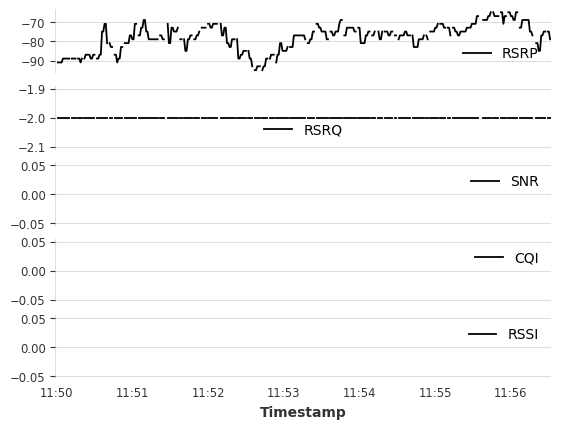

In [152]:
simple_plot(list_driving_down[0])

Utils for univariate

In [153]:
def collect_univariate_metrics(list_series, model_name, model, output_file, K=5, H=1):
    _path = os.path.join(checkpoints_path, "results", output_file)
    result_record = []
    for i, series in enumerate(list_series):
        for kpi in target_columns:
            # try:
            results = sliding_window_cross_validate_and_evaluate(
                model, series[kpi], K, H, 60, model_name
            )
            results["target"] = kpi
            result_record.append(results)

            # except Exception as e:
            #     print(f"Erro ao processar a serie {i} com {kpi}: {e}")
            #     continue

    result_record = pd.DataFrame(result_record)
    result_record.to_parquet(_path, compression="gzip")

    print(f"Saved in {_path}")
    return result_record

All list of series for training

In [154]:
list_static_strm = convert_dfs_to_ts(list_static_strm, target_columns)
list_driving_strm = convert_dfs_to_ts(list_driving_strm, target_columns)
list_static_down = convert_dfs_to_ts(list_static_down, target_columns)
list_driving_down = convert_dfs_to_ts(list_driving_down, target_columns)

<Axes: xlabel='Timestamp'>

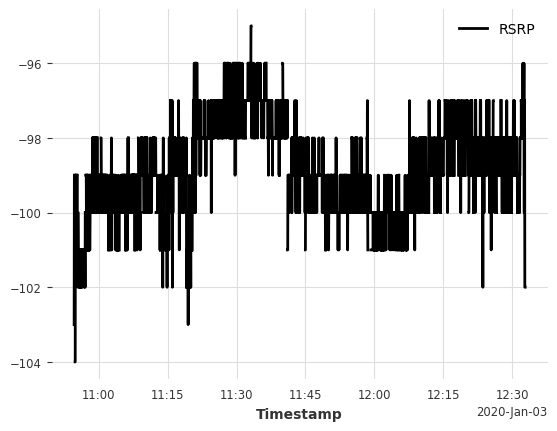

In [155]:
list_static_strm[0]["RSRP"].plot()

<Axes: xlabel='Timestamp'>

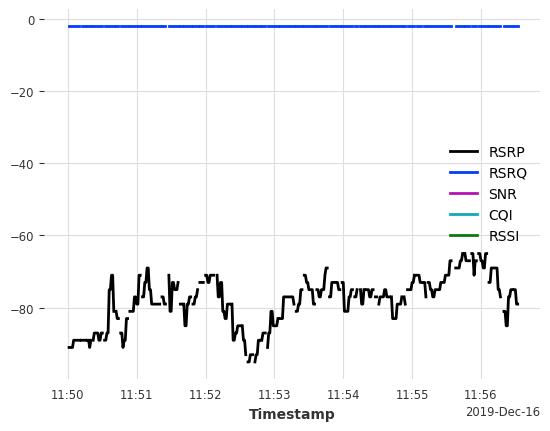

In [156]:
list_driving_down[0].plot()

### Pre-process all list

Save all scalars

In [157]:
# list_static_strm, scalers_static_strm = preprocess_list_ts(list_static_strm)
# list_driving_strm, scalers_driving_strm = preprocess_list_ts(list_driving_strm)
# list_static_down_transformed, scalers_static_down = preprocess_list_ts(list_static_down)
# list_driving_down_transformed, scalers_driving_down = preprocess_list_ts(list_driving_down)

In [158]:
# list_driving_down_transformed[0].plot()

# Baseline Forecast

In [159]:
all_stats = []

---

# Naive Forecast

In [160]:
model_name = "Naive"
naive_model = NaiveSeasonal(K=1)

Static Streaming

In [161]:
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_strm, model_name, naive_model, output_file, K, H
)

Processing Windows: 100%|██████████| 41/41 [00:00<00:00, 82.53it/s]


Saved in ..\checkpoints\results\uni_Naive_static_strm.gzip


In [162]:
result

,Time_Index,Model,Actuals,Preds,ElapsedTime,target
0,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[-101.0, -101.0, -100.5, -100.0, -100.0, -101....","[-102.0, -102.0, -102.0, -102.0, -102.0, -102....",1.904795,RSRP
1,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[-11.0, -11.0, -11.5, -11.999999999999998, -11...","[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10...",1.337812,RSRQ
2,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[1.0, 1.0, 2.0, 3.0000000000000013, 3.00000000...","[-4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4....",1.269951,SNR
3,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[9.0, 9.0, 10.0, 11.0, 11.0, 12.00000000000000...","[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13....",1.310919,CQI
4,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.423746,RSSI
...,...,...,...,...,...,...
85,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[-102.0, -102.0, -103.0, -103.0, -103.0, -101....","[-102.0, -102.0, -102.0, -102.0, -102.0, -102....",0.577605,RSRP
86,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[-17.0, -17.0, -18.0, -18.0, -18.0, -17.0, -17...","[-16.0, -16.0, -16.0, -16.0, -16.0, -16.0, -16...",0.551915,RSRQ
87,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[-4.0, -4.0, -0.9999999999999994, -0.999999999...","[4.000000000000001, 4.000000000000001, 4.00000...",0.570857,SNR
88,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 9.0...","[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12....",0.560584,CQI


In [163]:
metrics = compare_series_metrics(result)

In [164]:
metrics

,Time_Index,Model,Actuals,Preds,ElapsedTime,target,MAE,RMSE,MSE
0,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[-101.0, -101.0, -100.5, -100.0, -100.0, -101....","[-102.0, -102.0, -102.0, -102.0, -102.0, -102....",1.904795,RSRP,0.481633,0.820652,0.673469
1,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[-11.0, -11.0, -11.5, -11.999999999999998, -11...","[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10...",1.337812,RSRQ,1.629592,2.228182,4.964796
2,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[1.0, 1.0, 2.0, 3.0000000000000013, 3.00000000...","[-4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4....",1.269951,SNR,4.066327,5.356810,28.695408
3,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[9.0, 9.0, 10.0, 11.0, 11.0, 12.00000000000000...","[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13....",1.310919,CQI,1.756633,2.353840,5.540561
4,"[2020-01-03T10:55:29.000000000, 2020-01-03T10:...",Naive,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.423746,RSSI,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
85,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[-102.0, -102.0, -103.0, -103.0, -103.0, -101....","[-102.0, -102.0, -102.0, -102.0, -102.0, -102....",0.577605,RSRP,0.682927,1.149761,1.321951
86,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[-17.0, -17.0, -18.0, -18.0, -18.0, -17.0, -17...","[-16.0, -16.0, -16.0, -16.0, -16.0, -16.0, -16...",0.551915,RSRQ,1.750000,2.402869,5.773780
87,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[-4.0, -4.0, -0.9999999999999994, -0.999999999...","[4.000000000000001, 4.000000000000001, 4.00000...",0.570857,SNR,2.735366,3.531997,12.475000
88,"[2019-12-19T15:01:37.000000000, 2019-12-19T15:...",Naive,"[12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 9.0...","[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12....",0.560584,CQI,1.179268,2.081129,4.331098


In [25]:
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Naive CQI     0.000000  0.749132    0.908980  1.240161  1.959009  0.918565   
      RSRP    0.000000  0.492291    0.639074  0.789102  3.310714  0.844282   
      RSRQ    0.000000  1.124016    1.609693  1.741406  1.990833  1.253969   
      RSSI    0.497923  0.879528    1.014759  1.091823  2.914161  1.116069   
      SNR     0.000000  2.154209    3.524877  4.009537  4.699537  2.795619   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model target                                                                    
Naive CQI     0.000000  1.546046     1.824856  2.125874   3.061473   1.622463   
      RSRP    0.000000  0.831631     1.115906  1.434237  18.466282   2.263261   
      RSRQ    0.000000  1.725747     2.231961  2.352573   2.780513   1.755961   
      RSSI    1.023011  1.465969     1.736799  2.197757   4.666222   2.030000   
      SNR     0.000000  3.205402     4.950212  5.400741   6.112620   3.799598   

               MSE_Min     MSE_1Q  MSE_Median     MSE_3Q     MSE_Max  \
Model target                                                           
Naive CQI     0.000000   2.391430    3.333634   4.520008    9.372619   
      RSRP    0.000000   0.691626    1.246392   2.060968  341.003571   
      RSRQ    0.000000   2.981293    4.981663   5.535239    7.731250   
      RSSI    1.046552   2.149072    3.020813   4.842653   21.773628   
      SNR     0.000000  10.295845   24.504642  29.168644   37.364120   

               MSE_Mean     Activity  
Model target                          
Naive CQI      3.481508  static_strm  
      RSRP    21.697838  static_strm  
      RSRQ     3.975070  static_strm  
      RSSI     5.065074  static_strm  
      SNR     19.049076  static_strm

Driving Streaming

In [26]:
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_strm, model_name, naive_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 278.38it/s]


Saved in ..\checkpoints\results\uni_Naive_driving_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Naive CQI     0.147059  1.351230    1.685495  1.928125  2.405000  1.579573   
      RSRP    0.684884  2.788097    3.372619  3.648255  6.190909  3.331905   
      RSRQ    0.222222  1.369397    1.600000  1.836997  2.283333  1.546443   
      RSSI    0.271296  2.404182    2.976404  3.594516  7.042500  2.969613   
      SNR     0.511111  3.822012    4.609256  5.443546  8.408333  4.474585   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model target                                                                    
Naive CQI     0.488094  2.219215     2.599053  2.886835   3.439961   2.491077   
      RSRP    0.979143  4.318783     4.885226  5.577618   9.556293   5.072434   
      RSRQ    0.666667  2.096818     2.475967  2.796591   3.801316   2.387728   
      RSSI    0.984839  3.754524     4.682875  5.599775   9.688804   4.757208   
      SNR     1.478550  5.635420     6.388103  7.224561  11.471825   6.470510   

               MSE_Min     MSE_1Q  MSE_Median     MSE_3Q     MSE_Max  \
Model target                                                           
Naive CQI     0.238235   4.925179    6.756037   8.333948   11.833333   
      RSRP    0.958721  18.651892   23.866766  31.111789   91.322727   
      RSRQ    0.444444   4.396818    6.130621   7.821032   14.450000   
      RSSI    0.969907  14.098926   21.929319  31.372275   93.872917   
      SNR     2.186111  31.758292   40.812183  52.195397  131.602778   

               MSE_Mean      Activity  
Model target                           
Naive CQI      6.649752  driving_strm  
      RSRP    27.727846  driving_strm  
      RSRQ     6.121617  driving_strm  
      RSSI    25.193698  driving_strm  
      SNR     44.361116  driving_strm

Static Downloading

In [27]:
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_down, model_name, naive_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 110/110 [00:00<00:00, 219.58it/s]


Saved in ..\checkpoints\results\uni_Naive_static_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Naive CQI     0.504386  1.705738    1.746970  1.851724  2.530556  1.667875   
      RSRP    0.458772  0.480455    0.650000  0.690230  0.848361  0.625563   
      RSRQ    1.752879  1.843966    1.910965  2.118033  2.209259  1.967020   
      RSSI    0.279310  0.480328    0.508182  0.666667  0.711111  0.529120   
      SNR     2.804825  2.816092    2.848634  2.977778  3.366818  2.962829   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  RMSE_Max  RMSE_Mean  \
Model target                                                                   
Naive CQI     1.221099  2.283035     2.398884  2.501034  3.353849   2.351580   
      RSRP    0.826021  0.897513     0.937063  1.074344  1.314571   1.009902   
      RSRQ    2.437414  2.501044     2.663444  2.827827  2.841448   2.654235   
      RSSI    0.728721  1.013839     1.126763  1.215639  2.063325   1.229657   
      SNR     3.816105  3.821158     3.852069  3.860004  4.606465   3.991160   

                MSE_Min     MSE_1Q  MSE_Median     MSE_3Q    MSE_Max  \
Model target                                                           
Naive CQI      1.491082   5.212250    5.754646   6.255172  11.248302   
      RSRP     0.682310   0.805530    0.878086   1.154215   1.728097   
      RSRQ     5.940985   6.255220    7.093933   7.996605   8.073825   
      RSSI     0.531034   1.027869    1.269596   1.477778   4.257310   
      SNR     14.562654  14.601245   14.838434  14.899635  21.219520   

               MSE_Mean     Activity  
Model target                          
Naive CQI      5.992291  static_down  
      RSRP     1.049648  static_down  
      RSRQ     7.072114  static_down  
      RSSI     1.712717  static_down  
      SNR     16.024298  static_down

Driving Downloading

In [28]:
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_down, model_name, naive_model, output_file, K, H
)

Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 244.71it/s]


Saved in ..\checkpoints\results\uni_Naive_driving_down.gzip


In [29]:
metrics = compare_series_metrics(result)

In [30]:
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Naive CQI     0.171429  0.956297    1.725379  2.190686  3.933333  1.680803   
      RSRP    2.078030  2.747993    3.084301  3.677091  6.691667  3.376826   
      RSRQ    0.000000  0.837378    1.706194  1.822066  2.266667  1.338931   
      RSSI    0.564286  1.506529    2.400000  3.764430  4.291860  2.611906   
      SNR     0.435714  4.004270    4.508929  5.192620  9.141667  4.356977   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model target                                                                    
Naive CQI     0.606512  2.028595     2.754911  3.043318   4.845101   2.593840   
      RSRP    3.605901  4.250440     4.620043  5.325779   9.550960   5.054596   
      RSRQ    0.000000  1.392876     2.333868  2.701152   3.368208   2.088692   
      RSSI    1.592393  3.006570     3.894878  5.979762   7.635196   4.450329   
      SNR     1.220363  6.408992     7.116575  7.781021  11.759571   6.772632   

                MSE_Min     MSE_1Q  MSE_Median     MSE_3Q     MSE_Max  \
Model target                                                            
Naive CQI      0.367857   4.115387    7.589535   9.275036   23.475000   
      RSRP    13.002525  18.067697   21.346131  28.367063   91.220833   
      RSRQ     0.000000   1.950787    5.447566   7.299491   11.344823   
      RSSI     2.535714   9.042302   15.170072  35.757803   58.296216   
      SNR      1.489286  41.075211   50.645646  60.563669  138.287500   

               MSE_Mean      Activity  
Model target                           
Naive CQI      7.680950  driving_down  
      RSRP    27.456151  driving_down  
      RSRQ     5.136576  driving_down  
      RSSI    22.907277  driving_down  
      SNR     50.917157  driving_down

In [31]:
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"])

MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model target Activity                                                           
Naive CQI    static_strm   0.000000  0.749132    0.908980  1.240161  1.959009   
      RSRP   static_strm   0.000000  0.492291    0.639074  0.789102  3.310714   
      RSRQ   static_strm   0.000000  1.124016    1.609693  1.741406  1.990833   
      RSSI   static_strm   0.497923  0.879528    1.014759  1.091823  2.914161   
      SNR    static_strm   0.000000  2.154209    3.524877  4.009537  4.699537   
      CQI    driving_strm  0.147059  1.351230    1.685495  1.928125  2.405000   
      RSRP   driving_strm  0.684884  2.788097    3.372619  3.648255  6.190909   
      RSRQ   driving_strm  0.222222  1.369397    1.600000  1.836997  2.283333   
      RSSI   driving_strm  0.271296  2.404182    2.976404  3.594516  7.042500   
      SNR    driving_strm  0.511111  3.822012    4.609256  5.443546  8.408333   
      CQI    static_down   0.504386  1.705738    1.746970  1.851724  2.530556   
      RSRP   static_down   0.458772  0.480455    0.650000  0.690230  0.848361   
      RSRQ   static_down   1.752879  1.843966    1.910965  2.118033  2.209259   
      RSSI   static_down   0.279310  0.480328    0.508182  0.666667  0.711111   
      SNR    static_down   2.804825  2.816092    2.848634  2.977778  3.366818   
      CQI    driving_down  0.171429  0.956297    1.725379  2.190686  3.933333   
      RSRP   driving_down  2.078030  2.747993    3.084301  3.677091  6.691667   
      RSRQ   driving_down  0.000000  0.837378    1.706194  1.822066  2.266667   
      RSSI   driving_down  0.564286  1.506529    2.400000  3.764430  4.291860   
      SNR    driving_down  0.435714  4.004270    4.508929  5.192620  9.141667   

                           MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median  \
Model target Activity                                                  
Naive CQI    static_strm   0.918565  0.000000  1.546046     1.824856   
      RSRP   static_strm   0.844282  0.000000  0.831631     1.115906   
      RSRQ   static_strm   1.253969  0.000000  1.725747     2.231961   
      RSSI   static_strm   1.116069  1.023011  1.465969     1.736799   
      SNR    static_strm   2.795619  0.000000  3.205402     4.950212   
      CQI    driving_strm  1.579573  0.488094  2.219215     2.599053   
      RSRP   driving_strm  3.331905  0.979143  4.318783     4.885226   
      RSRQ   driving_strm  1.546443  0.666667  2.096818     2.475967   
      RSSI   driving_strm  2.969613  0.984839  3.754524     4.682875   
      SNR    driving_strm  4.474585  1.478550  5.635420     6.388103   
      CQI    static_down   1.667875  1.221099  2.283035     2.398884   
      RSRP   static_down   0.625563  0.826021  0.897513     0.937063   
      RSRQ   static_down   1.967020  2.437414  2.501044     2.663444   
      RSSI   static_down   0.529120  0.728721  1.013839     1.126763   
      SNR    static_down   2.962829  3.816105  3.821158     3.852069   
      CQI    driving_down  1.680803  0.606512  2.028595     2.754911   
      RSRP   driving_down  3.376826  3.605901  4.250440     4.620043   
      RSRQ   driving_down  1.338931  0.000000  1.392876     2.333868   
      RSSI   driving_down  2.611906  1.592393  3.006570     3.894878   
      SNR    driving_down  4.356977  1.220363  6.408992     7.116575   

                            RMSE_3Q   RMSE_Max  RMSE_Mean    MSE_Min  \
Model target Activity                                                  
Naive CQI    static_strm   2.125874   3.061473   1.622463   0.000000   
      RSRP   static_strm   1.434237  18.466282   2.263261   0.000000   
      RSRQ   static_strm   2.352573   2.780513   1.755961   0.000000   
      RSSI   static_strm   2.197757   4.666222   2.030000   1.046552   
      SNR    static_strm   5.400741   6.112620   3.799598   0.000000   
      CQI    driving_strm  2.886835   3.439961   2.491077   0.238235   
      RSRP   driving_strm  5.577618   9.556293   5.072434   0.958721   
      RSRQ  

---

# Naive Drift

In [32]:
model_name = "NaiveDrift"
naive_drift_model = NaiveDrift()

In [33]:
# Static Streaming

activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_strm, model_name, naive_drift_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 41/41 [00:00<00:00, 230.32it/s]


Saved in ..\checkpoints\results\uni_NaiveDrift_static_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model      target                                                       
NaiveDrift CQI     0.003401  0.934456    1.075074  1.442487  2.144126   
           RSRP    0.001701  0.548560    0.720238  0.907930  3.727624   
           RSRQ    0.000000  1.236494    1.737716  1.890123  2.196650   
           RSSI    0.568094  1.000223    1.134458  1.224167  3.360680   
           SNR     0.005612  2.313666    3.877333  4.302855  5.011839   

                   MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model      target                                                        
NaiveDrift CQI     1.063821  0.031174  1.612696     1.962581  2.310814   
           RSRP    0.969001  0.015587  0.887365     1.201653  1.489817   
           RSRQ    1.362094  0.000000  1.852017     2.362938  2.520601   
           RSSI    1.270822  1.064192  1.554886     1.845313  2.292438   
           SNR     3.028643  0.040044  3.437037     5.268628  5.772185   

                    RMSE_Max  RMSE_Mean   MSE_Min     MSE_1Q  MSE_Median  \
Model      target                                                          
NaiveDrift CQI      3.348398   1.755862  0.000972   2.606091    3.855940   
           RSRP    18.630075   2.373708  0.000243   0.787494    1.443976   
           RSRQ     3.032736   1.878092  0.000000   3.431694    5.583568   
           RSSI     4.911231   2.157622  1.132504   2.417681    3.407937   
           SNR      6.487889   4.091161  0.001603  11.840712   27.763785   

                      MSE_3Q     MSE_Max   MSE_Mean     Activity  
Model      target                                                 
NaiveDrift CQI      5.340192   11.211769   4.048093  static_strm  
           RSRP     2.224385  347.079686  22.538449  static_strm  
           RSRQ     6.354227    9.197489   4.517519  static_strm  
           RSSI     5.278654   24.120188   5.704538  static_strm  
           SNR     33.318623   42.092709  21.717119  static_strm

In [34]:
# Driving Streaming

activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_strm, model_name, naive_drift_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 240.60it/s]


Saved in ..\checkpoints\results\uni_NaiveDrift_driving_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model      target                                                       
NaiveDrift CQI     0.221609  1.475440    1.893855  2.084386  2.690510   
           RSRP    0.748339  3.143559    3.697250  4.032630  6.606308   
           RSRQ    0.250794  1.527173    1.817160  1.962014  2.532499   
           RSSI    0.157955  2.575730    3.281423  3.999402  7.301973   
           SNR     0.360034  4.010604    4.826672  5.841321  9.017687   

                   MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model      target                                                        
NaiveDrift CQI     1.743119  0.552671  2.387041     2.746347  3.062000   
           RSRP    3.632986  1.030046  4.612666     5.433765  6.172837   
           RSRQ    1.706552  0.695303  2.314067     2.650140  2.958599   
           RSSI    3.277916  0.490414  4.058781     5.090828  6.042695   
           SNR     4.805090  1.097659  5.927645     6.832804  7.858867   

                    RMSE_Max  RMSE_Mean   MSE_Min     MSE_1Q  MSE_Median  \
Model      target                                                          
NaiveDrift CQI      3.691631   2.666146  0.305445   5.697967    7.542530   
           RSRP    10.157302   5.470071  1.060996  21.278391   29.527972   
           RSRQ     4.126743   2.562538  0.483447   5.354939    7.023421   
           RSSI    10.655188   5.126526  0.240506  16.473720   25.916930   
           SNR     12.584225   6.910420  1.204855  35.137322   46.688822   

                      MSE_3Q     MSE_Max   MSE_Mean      Activity  
Model      target                                                  
NaiveDrift CQI      9.378082   13.628139   7.597924  driving_strm  
           RSRP    38.104138  103.170779  32.091412  driving_strm  
           RSRQ     8.754164   17.030010   7.048171  driving_strm  
           RSSI    36.531772  113.533030  29.348597  driving_strm  
           SNR     61.763462  158.362715  50.888216  driving_strm

In [35]:
# Static Downloading

activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_down, model_name, naive_drift_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 110/110 [00:00<00:00, 182.05it/s]


Saved in ..\checkpoints\results\uni_NaiveDrift_static_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model      target                                                       
NaiveDrift CQI     0.679117  1.825427    1.872297  2.009524  2.754649   
           RSRP    0.546285  0.558840    0.730159  0.779334  0.970693   
           RSRQ    1.874963  1.984283    2.145847  2.263934  2.286413   
           RSSI    0.394933  0.611877    0.655955  0.802811  0.808390   
           SNR     3.031731  3.082501    3.131789  3.171202  3.573244   

                   MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model      target                                                        
NaiveDrift CQI     1.828203  1.334198  2.432525     2.547193  2.650298   
           RSRP    0.717062  0.882574  0.973262     1.013405  1.155711   
           RSRQ    2.111088  2.579081  2.671662     2.940887  2.943553   
           RSSI    0.654793  0.809266  1.123385     1.276537  1.282750   
           SNR     3.198093  4.037471  4.148639     4.157148  4.250481   

                   RMSE_Max  RMSE_Mean    MSE_Min     MSE_1Q  MSE_Median  \
Model      target                                                          
NaiveDrift CQI     3.649323   2.522707   1.780084   5.917178    6.488190   
           RSRP    1.464383   1.097867   0.778937   0.947238    1.026990   
           RSRQ    3.027817   2.832600   6.651660   7.137779    8.648817   
           RSSI    2.282956   1.354979   0.654911   1.261994    1.629546   
           SNR     4.885888   4.295925  16.301176  17.211206   17.281881   

                      MSE_3Q    MSE_Max   MSE_Mean     Activity  
Model      target                                                
NaiveDrift CQI      7.024078  13.317557   6.905417  static_down  
           RSRP     1.335669   2.144419   1.246651  static_down  
           RSRQ     8.664504   9.167676   8.054087  static_down  
           RSSI     1.645449   5.211888   2.080757  static_down  
           SNR     18.066589  23.871899  18.546550  static_down

In [36]:
# Driving Downloading

activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_down, model_name, naive_drift_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 217.60it/s]


Saved in ..\checkpoints\results\uni_NaiveDrift_driving_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model      target                                                       
NaiveDrift CQI     0.214796  1.146023    1.916520  2.463501  4.207483   
           RSRP    2.424830  3.207870    3.560945  4.156487  6.937245   
           RSRQ    0.000000  0.937224    1.883781  2.014728  2.306969   
           RSSI    0.757289  1.685375    3.125850  4.231031  4.935815   
           SNR     0.425510  4.279413    4.916759  5.559820  9.666837   

                   MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model      target                                                        
NaiveDrift CQI     1.860936  0.711712  2.256518     3.022408  3.253367   
           RSRP    3.821494  3.908135  4.660665     5.369643  5.992408   
           RSRQ    1.489478  0.000000  1.534360     2.528037  2.969624   
           RSSI    2.958889  1.906263  3.095789     4.259135  6.593676   
           SNR     4.709976  1.096096  6.880949     7.285509  8.458470   

                    RMSE_Max  RMSE_Mean    MSE_Min     MSE_1Q  MSE_Median  \
Model      target                                                           
NaiveDrift CQI      5.107239   2.795448   0.506534   5.093312    9.134952   
           RSRP     9.732815   5.624499  15.273519  21.722724   28.834435   
           RSRQ     3.527713   2.263933   0.000000   2.373966    6.391177   
           RSSI     7.917079   4.841236   3.633840   9.590367   18.140233   
           SNR     12.621466   7.285368   1.201426  47.370409   53.078640   

                      MSE_3Q     MSE_Max   MSE_Mean      Activity  
Model      target                                                  
NaiveDrift CQI     10.593900   26.083892   8.848955  driving_down  
           RSRP    35.909077   94.727685  33.543541  driving_down  
           RSRQ     8.825671   12.444761   5.984210  driving_down  
           RSSI    43.478961   62.680137  27.113411  driving_down  
           SNR     71.558897  159.301397  58.890360  driving_down

In [37]:
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"])

MAE_Min    MAE_1Q  MAE_Median    MAE_3Q  \
Model      target Activity                                                 
Naive      CQI    static_strm   0.000000  0.749132    0.908980  1.240161   
           RSRP   static_strm   0.000000  0.492291    0.639074  0.789102   
           RSRQ   static_strm   0.000000  1.124016    1.609693  1.741406   
           RSSI   static_strm   0.497923  0.879528    1.014759  1.091823   
           SNR    static_strm   0.000000  2.154209    3.524877  4.009537   
           CQI    driving_strm  0.147059  1.351230    1.685495  1.928125   
           RSRP   driving_strm  0.684884  2.788097    3.372619  3.648255   
           RSRQ   driving_strm  0.222222  1.369397    1.600000  1.836997   
           RSSI   driving_strm  0.271296  2.404182    2.976404  3.594516   
           SNR    driving_strm  0.511111  3.822012    4.609256  5.443546   
           CQI    static_down   0.504386  1.705738    1.746970  1.851724   
           RSRP   static_down   0.458772  0.480455    0.650000  0.690230   
           RSRQ   static_down   1.752879  1.843966    1.910965  2.118033   
           RSSI   static_down   0.279310  0.480328    0.508182  0.666667   
           SNR    static_down   2.804825  2.816092    2.848634  2.977778   
           CQI    driving_down  0.171429  0.956297    1.725379  2.190686   
           RSRP   driving_down  2.078030  2.747993    3.084301  3.677091   
           RSRQ   driving_down  0.000000  0.837378    1.706194  1.822066   
           RSSI   driving_down  0.564286  1.506529    2.400000  3.764430   
           SNR    driving_down  0.435714  4.004270    4.508929  5.192620   
NaiveDrift CQI    static_strm   0.003401  0.934456    1.075074  1.442487   
           RSRP   static_strm   0.001701  0.548560    0.720238  0.907930   
           RSRQ   static_strm   0.000000  1.236494    1.737716  1.890123   
           RSSI   static_strm   0.568094  1.000223    1.134458  1.224167   
           SNR    static_strm   0.005612  2.313666    3.877333  4.302855   
           CQI    driving_strm  0.221609  1.475440    1.893855  2.084386   
           RSRP   driving_strm  0.748339  3.143559    3.697250  4.032630   
           RSRQ   driving_strm  0.250794  1.527173    1.817160  1.962014   
           RSSI   driving_strm  0.157955  2.575730    3.281423  3.999402   
           SNR    driving_strm  0.360034  4.010604    4.826672  5.841321   
           CQI    static_down   0.679117  1.825427    1.872297  2.009524   
           RSRP   static_down   0.546285  0.558840    0.730159  0.779334   
           RSRQ   static_down   1.874963  1.984283    2.145847  2.263934   
           RSSI   static_down   0.394933  0.611877    0.655955  0.802811   
           SNR    static_down   3.031731  3.082501    3.131789  3.171202   
           CQI    driving_down  0.214796  1.146023    1.916520  2.463501   
           RSRP   driving_down  2.424830  3.207870    3.560945  4.156487   
           RSRQ   driving_down  0.000000  0.937224    1.883781  2.014728   
           RSSI   driving_down  0.757289  1.685375    3.125850  4.231031   
           SNR    driving_down  0.425510  4.279413    4.916759  5.559820   

                                 MAE_Max  MAE_Mean  RMSE_Min   RMSE_1Q  \
Model      target Activity                                               
Naive      CQI    static_strm   1.959009  0.918565  0.000000  1.546046   
           RSRP   static_strm   3.310714  0.844282  0.000000  0.831631   
           RSRQ   static_strm   1.990833  1.253969  0.000000  1.725747   
           RSSI   static_strm   2.914161  1.116069  1.023011  1.465969   
           SNR    static_strm   4.699537  2.795619  0.000000  3.205402   
           CQI    driving_strm  2.405000  1.579573  0.488094  2.219215   
           RSRP   driving_strm  6.190909  3.331905  0.979143  4.318783   
           RSRQ   driving_strm  2.283333  1.546443  0.666667  2.096818   
           RSSI   driving_strm  7.042500  2.969613  0.984839  3.754524   
           SNR    driving_

# Naive Moving Average

In [38]:
model_name = "NaiveMovingAverage"
naive_ma_model = NaiveMovingAverage(input_chunk_length=K)

In [39]:
# Static Streaming

activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_strm, model_name, naive_ma_model, output_file, K, H
)


metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 41/41 [00:00<00:00, 201.69it/s]


Saved in ..\checkpoints\results\uni_NaiveMovingAverage_static_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model              target                                                       
NaiveMovingAverage CQI     0.001177  1.169002    1.503034  1.648956  2.047292   
                   RSRP    0.002705  0.570308    0.736491  0.945649  6.174870   
                   RSRQ    0.001424  1.086016    1.456192  1.512683  3.122922   
                   RSSI    0.695024  1.158000    1.220365  1.351258  6.178456   
                   SNR     0.039513  1.849418    3.012166  3.391439  5.333553   

                           MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median  \
Model              target                                              
NaiveMovingAverage CQI     1.206985  0.010230  1.446521     1.868964   
                   RSRP    1.105752  0.026044  0.816814     1.076983   
                   RSRQ    1.229095  0.009604  1.470008     1.847014   
                   RSSI    1.630535  1.033397  1.606836     1.806547   
                   SNR     2.492873  0.250486  2.670998     3.760354   

                            RMSE_3Q   RMSE_Max  RMSE_Mean   MSE_Min    MSE_1Q  \
Model              target                                                       
NaiveMovingAverage CQI     2.073334   2.629692   1.583252  0.000105  2.094687   
                   RSRP    1.595881  18.490572   2.566286  0.000678  0.669687   
                   RSRQ    1.909493   4.823295   1.642410  0.000092  2.175074   
                   RSSI    2.003443   8.464982   2.368013  1.067909  2.582254   
                   SNR     4.335820   7.260258   3.254357  0.062743  7.146817   

                           MSE_Median     MSE_3Q     MSE_Max   MSE_Mean  \
Model              target                                                 
NaiveMovingAverage CQI       3.493503   4.298750    6.915282   3.185003   
                   RSRP      1.160892   2.573569  341.901246  25.355775   
                   RSRQ      3.411493   3.646180   23.264172   3.879228   
                   RSSI      3.265997   4.013877   71.655917   9.322572   
                   SNR      14.160198  18.799468   52.711349  13.941249   

                              Activity  
Model              target               
NaiveMovingAverage CQI     static_strm  
                   RSRP    static_strm  
                   RSRQ    static_strm  
                   RSSI    static_strm  
                   SNR     static_strm

In [40]:
# Driving Streaming


activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_strm, model_name, naive_ma_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 215.34it/s]


Saved in ..\checkpoints\results\uni_NaiveMovingAverage_driving_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q  \
Model              target                                             
NaiveMovingAverage CQI     0.497169  1.615826    1.895225  2.222977   
                   RSRP    0.745675  4.654352    5.673360  6.547533   
                   RSRQ    0.670866  1.561010    1.903540  2.349275   
                   RSSI    1.664047  3.635006    4.881942  5.976627   
                   SNR     1.107640  4.193516    5.065462  6.014829   

                             MAE_Max  MAE_Mean  RMSE_Min   RMSE_1Q  \
Model              target                                            
NaiveMovingAverage CQI      2.905769  1.875244  1.028778  2.201289   
                   RSRP    11.827830  5.646916  0.960524  6.238336   
                   RSRQ     5.170827  2.000043  1.418777  2.290445   
                   RSSI     9.696502  4.970440  2.027808  5.798603   
                   SNR      8.832614  5.051756  2.925937  5.975126   

                           RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model              target                                                
NaiveMovingAverage CQI        2.508944  2.873098   3.809582   2.507242   
                   RSRP       7.650826  8.754750  15.607127   7.596985   
                   RSRQ       2.684954  3.238140   6.564658   2.797378   
                   RSSI       7.091065  7.997735  11.830862   6.990660   
                   SNR        6.987369  7.969426   9.908901   6.855665   

                            MSE_Min     MSE_1Q  MSE_Median     MSE_3Q  \
Model              target                                               
NaiveMovingAverage CQI     1.058385   4.846805    6.294873   8.254699   
                   RSRP    0.922607  38.923292   58.537752  76.646305   
                   RSRQ    2.012930   5.246154    7.209478  10.486431   
                   RSSI    4.112004  33.652844   50.283276  63.964051   
                   SNR     8.561108  35.721816   48.823351  63.511822   

                              MSE_Max   MSE_Mean      Activity  
Model              target                                       
NaiveMovingAverage CQI      14.512918   6.594769  driving_strm  
                   RSRP    243.582398  62.653499  driving_strm  
                   RSRQ     43.094735   8.576469  driving_strm  
                   RSSI    139.969286  52.251171  driving_strm  
                   SNR      98.186309  49.251204  driving_strm

In [41]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_static_down, model_name, naive_ma_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 110/110 [00:00<00:00, 207.56it/s]


Saved in ..\checkpoints\results\uni_NaiveMovingAverage_static_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model              target                                                       
NaiveMovingAverage CQI     1.383306  1.515137    1.548465  1.658344  1.741002   
                   RSRP    0.540368  0.658413    0.729232  0.767190  0.854967   
                   RSRQ    1.591106  1.788251    1.806657  1.809591  2.122079   
                   RSSI    0.613292  0.769061    0.865996  1.003866  1.005398   
                   SNR     2.224688  2.313507    2.377424  2.437987  2.483738   

                           MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median  \
Model              target                                              
NaiveMovingAverage CQI     1.569251  1.849011  1.907932     1.974443   
                   RSRP    0.710034  0.738296  0.828082     0.940784   
                   RSRQ    1.823537  2.043218  2.141535     2.152047   
                   RSSI    0.851523  0.898152  1.106765     1.114930   
                   SNR     2.367469  2.898043  2.956845     3.000057   

                            RMSE_3Q  RMSE_Max  RMSE_Mean   MSE_Min    MSE_1Q  \
Model              target                                                      
NaiveMovingAverage CQI     2.154178  2.160483   2.009209  3.418840  3.640206   
                   RSRP    1.116686  1.140788   0.952927  0.545081  0.685720   
                   RSRQ    2.205491  2.579470   2.224352  4.174739  4.586171   
                   RSSI    1.613697  1.707584   1.288226  0.806678  1.224929   
                   SNR     3.006752  3.304960   3.033331  8.398650  8.742934   

                           MSE_Median    MSE_3Q    MSE_Max  MSE_Mean  \
Model              target                                              
NaiveMovingAverage CQI       3.898423  4.640484   4.667688  4.053128   
                   RSRP      0.885074  1.246987   1.301397  0.932852   
                   RSRQ      4.631304  4.864190   6.653667  4.982014   
                   RSSI      1.243070  2.604019   2.915843  1.758908   
                   SNR       9.000344  9.040559  10.922757  9.221049   

                              Activity  
Model              target               
NaiveMovingAverage CQI     static_down  
                   RSRP    static_down  
                   RSRQ    static_down  
                   RSSI    static_down  
                   SNR     static_down

In [42]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_driving_down, model_name, naive_ma_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 233.15it/s]


Saved in ..\checkpoints\results\uni_NaiveMovingAverage_driving_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model              target                                                       
NaiveMovingAverage CQI     0.310285  1.166223    1.863368  2.218254  2.894854   
                   RSRP    3.361234  4.666496    5.215952  5.808226  6.904509   
                   RSRQ    0.000000  0.856058    1.703187  1.959555  2.289019   
                   RSSI    1.203910  2.385319    4.842577  5.971642  6.830216   
                   SNR     0.655678  3.683510    4.872606  5.232361  6.320417   

                           MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median  \
Model              target                                              
NaiveMovingAverage CQI     1.667298  0.774120  1.797476     2.414239   
                   RSRP    5.222742  3.883514  6.353183     7.018491   
                   RSRQ    1.424883  0.000000  1.498430     2.245448   
                   RSSI    4.305720  2.837924  4.341093     6.938967   
                   SNR     4.194502  1.814510  6.009969     6.778369   

                            RMSE_3Q  RMSE_Max  RMSE_Mean    MSE_Min  \
Model              target                                             
NaiveMovingAverage CQI     2.773908  3.572491   2.272049   0.599262   
                   RSRP    7.578520  8.979586   6.984156  15.081680   
                   RSRQ    2.516160  3.861698   2.026266   0.000000   
                   RSSI    7.939269  9.531892   6.361276   8.053814   
                   SNR     6.933980  8.023959   5.980276   3.292447   

                              MSE_1Q  MSE_Median     MSE_3Q    MSE_Max  \
Model              target                                                
NaiveMovingAverage CQI      3.233661    5.828551   7.695334  12.762689   
                   RSRP    40.382592   49.304601  57.465955  80.632969   
                   RSRQ     2.250246    5.043459   6.331444  14.912709   
                   RSSI    18.930506   48.149270  63.045653  90.856961   
                   SNR     36.120023   45.946281  48.080369  64.383922   

                            MSE_Mean      Activity  
Model              target                           
NaiveMovingAverage CQI      5.782325  driving_down  
                   RSRP    50.452798  driving_down  
                   RSRQ     4.860888  driving_down  
                   RSSI    44.620829  driving_down  
                   SNR     39.038511  driving_down

In [43]:
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"])

MAE_Min    MAE_1Q  MAE_Median  \
Model              target Activity                                       
Naive              CQI    static_strm   0.000000  0.749132    0.908980   
                   RSRP   static_strm   0.000000  0.492291    0.639074   
                   RSRQ   static_strm   0.000000  1.124016    1.609693   
                   RSSI   static_strm   0.497923  0.879528    1.014759   
                   SNR    static_strm   0.000000  2.154209    3.524877   
                   CQI    driving_strm  0.147059  1.351230    1.685495   
                   RSRP   driving_strm  0.684884  2.788097    3.372619   
                   RSRQ   driving_strm  0.222222  1.369397    1.600000   
                   RSSI   driving_strm  0.271296  2.404182    2.976404   
                   SNR    driving_strm  0.511111  3.822012    4.609256   
                   CQI    static_down   0.504386  1.705738    1.746970   
                   RSRP   static_down   0.458772  0.480455    0.650000   
                   RSRQ   static_down   1.752879  1.843966    1.910965   
                   RSSI   static_down   0.279310  0.480328    0.508182   
                   SNR    static_down   2.804825  2.816092    2.848634   
                   CQI    driving_down  0.171429  0.956297    1.725379   
                   RSRP   driving_down  2.078030  2.747993    3.084301   
                   RSRQ   driving_down  0.000000  0.837378    1.706194   
                   RSSI   driving_down  0.564286  1.506529    2.400000   
                   SNR    driving_down  0.435714  4.004270    4.508929   
NaiveDrift         CQI    static_strm   0.003401  0.934456    1.075074   
                   RSRP   static_strm   0.001701  0.548560    0.720238   
                   RSRQ   static_strm   0.000000  1.236494    1.737716   
                   RSSI   static_strm   0.568094  1.000223    1.134458   
                   SNR    static_strm   0.005612  2.313666    3.877333   
                   CQI    driving_strm  0.221609  1.475440    1.893855   
                   RSRP   driving_strm  0.748339  3.143559    3.697250   
                   RSRQ   driving_strm  0.250794  1.527173    1.817160   
                   RSSI   driving_strm  0.157955  2.575730    3.281423   
                   SNR    driving_strm  0.360034  4.010604    4.826672   
                   CQI    static_down   0.679117  1.825427    1.872297   
                   RSRP   static_down   0.546285  0.558840    0.730159   
                   RSRQ   static_down   1.874963  1.984283    2.145847   
                   RSSI   static_down   0.394933  0.611877    0.655955   
                   SNR    static_down   3.031731  3.082501    3.131789   
                   CQI    driving_down  0.214796  1.146023    1.916520   
                   RSRP   driving_down  2.424830  3.207870    3.560945   
                   RSRQ   driving_down  0.000000  0.937224    1.883781   
                   RSSI   driving_down  0.757289  1.685375    3.125850   
                   SNR    driving_down  0.425510  4.279413    4.916759   
NaiveMovingAverage CQI    static_strm   0.001177  1.169002    1.503034   
                   RSRP   static_strm   0.002705  0.570308    0.736491   
                   RSRQ   static_strm   0.001424  1.086016    1.456192   
                   RSSI   static_strm   0.695024  1.158000    1.220365   
                   SNR    static_strm   0.039513  1.849418    3.012166   
                   CQI    driving_strm  0.497169  1.615826    1.895225   
                   RSRP   driving_strm  0.745675  4.654352    5.673360   
                   RSRQ   driving_strm  0.670866  1.561010    1.903540   
                   RSSI   driving_strm  1.664047  3.635006    4.881942   
                   SNR    driving_strm  1.107640  4.193516    5.065462   
                   CQI    static_down   1.383306  1.515137    1.548465   
                   RSRP   static_down   0.540368  0.658413    0.729232   
                   RSRQ   static_down   1.591

# Naive Mean

In [44]:
model_name = "NaiveMean"
naive_mean_model = NaiveMean()

In [45]:
# Static Streaming
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_static_strm, model_name, naive_mean_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 41/41 [00:00<00:00, 249.16it/s]


Saved in ..\checkpoints\results\uni_NaiveMean_static_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model     target                                                       
NaiveMean CQI     0.005000  1.188483    1.507159  1.661695  2.067524   
          RSRP    0.005000  0.568974    0.753187  0.961512  6.321222   
          RSRQ    0.000714  1.087424    1.455155  1.512119  3.218611   
          RSSI    0.693554  1.171914    1.233743  1.349129  6.291078   
          SNR     0.039000  1.855932    3.005483  3.390427  5.476000   

                  MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model     target                                                        
NaiveMean CQI     1.217077  0.026458  1.470983     1.875702  2.095834   
          RSRP    1.135469  0.040620  0.816116     1.093292  1.642710   
          RSRQ    1.236722  0.003780  1.479037     1.861012  1.905784   
          RSSI    1.647924  1.024494  1.616417     1.816401  2.003321   
          SNR     2.499827  0.246658  2.672002     3.762399  4.325815   

                   RMSE_Max  RMSE_Mean   MSE_Min    MSE_1Q  MSE_Median  \
Model     target                                                         
NaiveMean CQI      2.655963   1.595882  0.000700  2.167048    3.518774   
          RSRP    18.568654   2.598210  0.001650  0.668757    1.195537   
          RSRQ     4.979903   1.653973  0.000014  2.203997    3.463368   
          RSSI     8.652930   2.389075  1.049589  2.612871    3.301796   
          SNR      7.478877   3.274193  0.060840  7.152480   14.168799   

                     MSE_3Q     MSE_Max   MSE_Mean     Activity  
Model     target                                                 
NaiveMean CQI      4.392876    7.054142   3.232439  static_strm  
          RSRP     2.733685  344.794914  25.803529  static_strm  
          RSRQ     3.632058   24.799432   3.974201  static_strm  
          RSSI     4.013366   74.873191   9.608779  static_strm  
          SNR     18.712675   55.933600  14.082106  static_strm

In [46]:
# Driving Streaming
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_driving_strm, model_name, naive_mean_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


Saved in ..\checkpoints\results\uni_NaiveMean_driving_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q    MAE_Max  \
Model     target                                                        
NaiveMean CQI     0.505889  1.639214    1.890225  2.283919   2.953621   
          RSRP    0.751628  4.788051    5.836215  6.555568  12.160778   
          RSRQ    0.673444  1.573583    1.917804  2.384439   5.261556   
          RSSI    1.680713  3.685988    5.052976  6.058327   9.879200   
          SNR     1.221111  4.263889    5.099723  6.101187   8.638500   

                  MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model     target                                                        
NaiveMean CQI     1.892952  1.074227  2.215079     2.515345  2.896424   
          RSRP    5.778088  0.964756  6.397842     7.840100  9.080292   
          RSRQ    2.023553  1.481023  2.258968     2.687624  3.271188   
          RSSI    5.077088  2.046312  6.032970     7.200937  8.118957   
          SNR     5.105554  3.196215  6.015445     6.994953  8.056150   

                   RMSE_Max  RMSE_Mean    MSE_Min     MSE_1Q  MSE_Median  \
Model     target                                                           
NaiveMean CQI      3.858083   2.525256   1.153965   4.906599    6.327121   
          RSRP    15.659483   7.723356   0.930753  40.943473   61.467647   
          RSRQ     6.612531   2.822237   2.193428   5.103227    7.223344   
          RSSI    11.957086   7.121452   4.187394  36.419558   51.853522   
          SNR      9.659049   6.914620  10.215789  36.198444   48.933944   

                     MSE_3Q     MSE_Max   MSE_Mean      Activity  
Model     target                                                  
NaiveMean CQI      8.389341   14.884803   6.685118  driving_strm  
          RSRP    82.451828  245.219394  64.666877  driving_strm  
          RSRQ    10.700684   43.725567   8.718460  driving_strm  
          RSSI    65.918296  142.971900  54.193093  driving_strm  
          SNR     64.901914   93.297225  50.068961  driving_strm

In [47]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_static_down, model_name, naive_mean_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 110/110 [00:00<00:00, 258.36it/s]


Saved in ..\checkpoints\results\uni_NaiveMean_static_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model     target                                                       
NaiveMean CQI     1.405596  1.508240    1.548515  1.632704  1.741414   
          RSRP    0.546436  0.649519    0.726172  0.769825  0.852689   
          RSRQ    1.597739  1.777218    1.786298  1.803333  2.127836   
          RSSI    0.628690  0.780328    0.859778  1.002491  1.026170   
          SNR     2.213614  2.305724    2.383869  2.414370  2.480309   

                  MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model     target                                                        
NaiveMean CQI     1.567294  1.864986  1.902753     1.978742  2.143811   
          RSRP    0.708928  0.743403  0.817790     0.933469  1.131020   
          RSRQ    1.818485  2.053500  2.118663     2.138207  2.181927   
          RSSI    0.859491  0.892030  1.106496     1.117835  1.597884   
          SNR     2.359577  2.898829  2.940419     3.003035  3.009376   

                  RMSE_Max  RMSE_Mean   MSE_Min    MSE_1Q  MSE_Median  \
Model     target                                                        
NaiveMean CQI     2.149553   2.007969  3.478171  3.620469    3.915419   
          RSRP    1.137608   0.952658  0.552648  0.668781    0.871364   
          RSRQ    2.584156   2.215290  4.216863  4.488731    4.571927   
          RSSI    1.702903   1.283429  0.795717  1.224333    1.249554   
          SNR     3.291600   3.028652  8.403210  8.646065    9.018218   

                    MSE_3Q    MSE_Max  MSE_Mean     Activity  
Model     target                                              
NaiveMean CQI     4.595925   4.620576  4.046112  static_down  
          RSRP    1.279206   1.294153  0.933230  static_down  
          RSRQ    4.760806   6.677861  4.943238  static_down  
          RSSI    2.553234   2.899878  1.744543  static_down  
          SNR     9.056342  10.834628  9.191693  static_down

In [48]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_driving_down, model_name, naive_mean_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 205.95it/s]


Saved in ..\checkpoints\results\uni_NaiveMean_driving_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  \
Model     target                                                       
NaiveMean CQI     0.317429  1.179599    1.852031  2.244925  2.844333   
          RSRP    3.574000  4.796138    5.296747  6.105317  6.988143   
          RSRQ    0.000000  0.853509    1.716193  1.985061  2.314909   
          RSSI    1.286857  2.437614    5.081000  6.024782  7.050369   
          SNR     0.645625  3.747165    5.027510  5.330294  6.426605   

                  MAE_Mean  RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  \
Model     target                                                        
NaiveMean CQI     1.673037  0.784843  1.811464     2.407830  2.774644   
          RSRP    5.373277  4.144418  6.281347     7.103529  7.902703   
          RSRQ    1.448607  0.000000  1.481022     2.272598  2.486752   
          RSSI    4.429117  2.943429  4.595736     7.103013  7.976176   
          SNR     4.249552  1.828025  5.977337     6.894787  7.079934   

                  RMSE_Max  RMSE_Mean    MSE_Min     MSE_1Q  MSE_Median  \
Model     target                                                          
NaiveMean CQI     3.518177   2.274115   0.615979   3.285309    5.797648   
          RSRP    9.259234   7.160246  17.176200  39.457779   50.524866   
          RSRQ    3.891099   2.047261   0.000000   2.197834    5.167236   
          RSSI    9.773444   6.520886   8.663771  21.126822   50.452800   
          SNR     8.101014   6.023740   3.341676  35.732516   47.538092   

                     MSE_3Q    MSE_Max   MSE_Mean      Activity  
Model     target                                                 
NaiveMean CQI      7.698824  12.377567   5.774633  driving_down  
          RSRP    62.558896  85.733414  53.007420  driving_down  
          RSRQ     6.185601  15.140650   4.971852  driving_down  
          RSSI    63.635410  95.520205  46.878878  driving_down  
          SNR     50.128633  65.626425  39.727058  driving_down

In [49]:
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"])

MAE_Min    MAE_1Q  MAE_Median    MAE_3Q  \
Model     target Activity                                                 
Naive     CQI    static_strm   0.000000  0.749132    0.908980  1.240161   
          RSRP   static_strm   0.000000  0.492291    0.639074  0.789102   
          RSRQ   static_strm   0.000000  1.124016    1.609693  1.741406   
          RSSI   static_strm   0.497923  0.879528    1.014759  1.091823   
          SNR    static_strm   0.000000  2.154209    3.524877  4.009537   
...                                 ...       ...         ...       ...   
NaiveMean CQI    driving_down  0.317429  1.179599    1.852031  2.244925   
          RSRP   driving_down  3.574000  4.796138    5.296747  6.105317   
          RSRQ   driving_down  0.000000  0.853509    1.716193  1.985061   
          RSSI   driving_down  1.286857  2.437614    5.081000  6.024782   
          SNR    driving_down  0.645625  3.747165    5.027510  5.330294   

                                MAE_Max  MAE_Mean  RMSE_Min   RMSE_1Q  \
Model     target Activity                                               
Naive     CQI    static_strm   1.959009  0.918565  0.000000  1.546046   
          RSRP   static_strm   3.310714  0.844282  0.000000  0.831631   
          RSRQ   static_strm   1.990833  1.253969  0.000000  1.725747   
          RSSI   static_strm   2.914161  1.116069  1.023011  1.465969   
          SNR    static_strm   4.699537  2.795619  0.000000  3.205402   
...                                 ...       ...       ...       ...   
NaiveMean CQI    driving_down  2.844333  1.673037  0.784843  1.811464   
          RSRP   driving_down  6.988143  5.373277  4.144418  6.281347   
          RSRQ   driving_down  2.314909  1.448607  0.000000  1.481022   
          RSSI   driving_down  7.050369  4.429117  2.943429  4.595736   
          SNR    driving_down  6.426605  4.249552  1.828025  5.977337   

                               RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model     target Activity                                                    
Naive     CQI    static_strm      1.824856  2.125874   3.061473   1.622463   
          RSRP   static_strm      1.115906  1.434237  18.466282   2.263261   
          RSRQ   static_strm      2.231961  2.352573   2.780513   1.755961   
          RSSI   static_strm      1.736799  2.197757   4.666222   2.030000   
          SNR    static_strm      4.950212  5.400741   6.112620   3.799598   
...                                    ...       ...        ...        ...   
NaiveMean CQI    driving_down     2.407830  2.774644   3.518177   2.274115   
          RSRP   driving_down     7.103529  7.902703   9.259234   7.160246   
          RSRQ   driving_down     2.272598  2.486752   3.891099   2.047261   
          RSSI   driving_down     7.103013  7.976176   9.773444   6.520886   
          SNR    driving_down     6.894787  7.079934   8.101014   6.023740   

                                 MSE_Min     MSE_1Q  MSE_Median     MSE_3Q  \
Model     target Activity                                                    
Naive     CQI    static_strm    0.000000   2.391430    3.333634   4.520008   
          RSRP   static_strm    0.000000   0.691626    1.246392   2.060968   
          RSRQ   static_strm    0.000000   2.981293    4.981663   5.535239   
          RSSI   static_strm    1.046552   2.149072    3.020813   4.842653   
          SNR    static_strm    0.000000  10.295845   24.504642  29.168644   
...                                  ...        ...         ...        ...   
NaiveMean CQI    driving_down   0.615979   3.285309    5.797648   7.698824   
          RSRP   driving_down  17.176200  39.457779   50.524866  62.558896   
          RSRQ   driving_down   0.000000   2.197834    5.167236   6.185601   
          RSSI   driving_down   8.663771  21.126822   50.452800  63.635410   
          SNR    driving_down   3.341676  35.732516   47.538092  50.128633   

                                  MSE_Max   MSE_Mean  
Model     target Acti

# Statistical / Classic Models
---

# Exponential Smoothing

In [50]:
from darts.utils.utils import SeasonalityMode

In [51]:
model_name = "ExponentialSmoothing"
ets_model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)

In [52]:
# Static Streaming
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_static_strm, model_name, ets_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows:   0%|          | 0/98 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\ho

Saved in ..\checkpoints\results\uni_ExponentialSmoothing_static_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q  \
Model                target                                                 
ExponentialSmoothing CQI     3.164453e-14  0.941179    1.114907  1.449185   
                     RSRP    1.705242e-03  0.532885    0.733467  0.920372   
                     RSRQ    1.446445e-03  1.241267    1.717610  1.900172   
                     RSSI    5.664659e-01  1.062530    1.202043  1.307705   
                     SNR     3.790674e-03  2.248778    3.747746  4.072566   

                              MAE_Max  MAE_Mean      RMSE_Min   RMSE_1Q  \
Model                target                                               
ExponentialSmoothing CQI     2.103352  1.070398  1.879572e-13  1.548646   
                     RSRP    3.725869  0.959024  1.562880e-02  0.876844   
                     RSRQ    2.217500  1.363623  1.120562e-02  1.829658   
                     RSSI    3.664876  1.364922  1.071320e+00  1.630598   
                     SNR     4.732102  2.921446  2.938528e-02  3.312676   

                             RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model                target                                                
ExponentialSmoothing CQI        2.020984  2.269127   3.289119   1.733012   
                     RSRP       1.233378  1.471283  18.631478   2.349340   
                     RSRQ       2.340264  2.548488   3.281016   1.886408   
                     RSSI       1.814633  2.243776   5.272829   2.229201   
                     SNR        5.007015  5.449262   6.186979   3.935016   

                                  MSE_Min     MSE_1Q  MSE_Median     MSE_3Q  \
Model                target                                                   
ExponentialSmoothing CQI     3.532792e-26   2.412284    4.092252   5.149435   
                     RSRP    2.442595e-04   0.769071    1.522392   2.168109   
                     RSRQ    1.255660e-04   3.349554    5.476839   6.498569   
                     RSSI    1.147727e+00   2.659173    3.295722   5.152960   
                     SNR     8.634945e-04  11.018093   25.071777  29.694733   

                                MSE_Max   MSE_Mean     Activity  
Model                target                                      
ExponentialSmoothing CQI      10.818305   3.931674  static_strm  
                     RSRP    347.131971  22.384880  static_strm  
                     RSRQ     10.765063   4.591276  static_strm  
                     RSSI     27.802727   6.316113  static_strm  
                     SNR      38.278705  20.014982  static_strm

In [53]:
# Driving Streaming
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_driving_strm, model_name, ets_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 50.72it/s]


Saved in ..\checkpoints\results\uni_ExponentialSmoothing_driving_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q  \
Model                target                                             
ExponentialSmoothing CQI     0.224339  1.609552    1.814817  2.095120   
                     RSRP    0.763088  3.221404    3.720324  4.301706   
                     RSRQ    0.253885  1.532336    1.849286  2.053417   
                     RSSI    0.153499  2.408843    3.319033  4.298214   
                     SNR     0.360089  4.227721    4.906352  5.796682   

                              MAE_Max  MAE_Mean  RMSE_Min   RMSE_1Q  \
Model                target                                           
ExponentialSmoothing CQI     3.782523  1.792307  0.519710  2.355048   
                     RSRP    6.408544  3.783077  1.038590  4.649001   
                     RSRQ    2.606936  1.748114  0.696009  2.353520   
                     RSSI    7.799485  3.489625  0.487560  4.043024   
                     SNR     9.018345  4.855124  1.098074  6.053139   

                             RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model                target                                                
ExponentialSmoothing CQI        2.680194  3.147885   8.337527   2.783976   
                     RSRP       5.600608  7.052263  17.825560   6.011148   
                     RSRQ       2.593892  3.089235   6.939678   2.689258   
                     RSSI       5.444370  6.710262  11.889447   5.504826   
                     SNR        6.880311  8.101370  12.580908   7.042657   

                              MSE_Min     MSE_1Q  MSE_Median     MSE_3Q  \
Model                target                                               
ExponentialSmoothing CQI     0.270099   5.546299    7.184252   9.909196   
                     RSRP    1.078669  21.613231   31.372781  49.759961   
                     RSRQ    0.484429   5.539061    6.728289   9.543581   
                     RSSI    0.237715  16.346049   29.641266  45.027705   
                     SNR     1.205766  36.640824   47.338992  65.636626   

                                MSE_Max   MSE_Mean      Activity  
Model                target                                       
ExponentialSmoothing CQI      69.514353   9.210154  driving_strm  
                     RSRP    317.750583  41.985536  driving_strm  
                     RSRQ     48.159132   8.206498  driving_strm  
                     RSSI    141.358952  35.181970  driving_strm  
                     SNR     158.279248  52.938764  driving_strm

In [54]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_static_down, model_name, ets_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 110/110 [00:01<00:00, 60.72it/s]


Saved in ..\checkpoints\results\uni_ExponentialSmoothing_static_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q  \
Model                target                                             
ExponentialSmoothing CQI     0.797570  1.854218    1.881376  2.028453   
                     RSRP    0.559974  0.580648    0.770354  0.783812   
                     RSRQ    1.881746  2.000130    2.142281  2.236200   
                     RSSI    0.475876  0.612488    0.728292  0.740234   
                     SNR     2.884786  3.072692    3.156392  3.170376   

                              MAE_Max  MAE_Mean  RMSE_Min   RMSE_1Q  \
Model                target                                           
ExponentialSmoothing CQI     2.613359  1.834995  1.479707  2.461142   
                     RSRP    0.970720  0.733102  0.909325  0.974365   
                     RSRQ    2.332633  2.118598  2.575129  2.679661   
                     RSSI    0.875295  0.686437  0.985199  1.107835   
                     SNR     3.390264  3.134902  3.887984  4.029945   

                             RMSE_Median   RMSE_3Q  RMSE_Max  RMSE_Mean  \
Model                target                                               
ExponentialSmoothing CQI        2.531775  2.661569  3.505090   2.527857   
                     RSRP       1.030956  1.152885  1.464100   1.106326   
                     RSRQ       2.928374  3.003909  3.014119   2.840238   
                     RSSI       1.169812  1.402687  2.289339   1.390975   
                     SNR        4.128755  4.291741  4.558811   4.179447   

                               MSE_Min     MSE_1Q  MSE_Median     MSE_3Q  \
Model                target                                                
ExponentialSmoothing CQI      2.189534   6.057218    6.409887   7.083952   
                     RSRP     0.826871   0.949386    1.062871   1.329145   
                     RSRQ     6.631287   7.180581    8.575371   9.023469   
                     RSSI     0.970618   1.227299    1.368461   1.967532   
                     SNR     15.116422  16.240455   17.046617  18.419044   

                               MSE_Max   MSE_Mean     Activity  
Model                target                                     
ExponentialSmoothing CQI     12.285656   6.805249  static_down  
                     RSRP     2.143588   1.262372  static_down  
                     RSRQ     9.084910   8.099124  static_down  
                     RSSI     5.241071   2.154996  static_down  
                     SNR     20.782759  17.521059  static_down

In [55]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"
result = collect_univariate_metrics(
    list_driving_down, model_name, ets_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\hol

Saved in ..\checkpoints\results\uni_ExponentialSmoothing_driving_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q  \
Model                target                                             
ExponentialSmoothing CQI     0.200504  1.159032    1.971011  2.431192   
                     RSRP    2.408008  3.272907    3.621871  4.275042   
                     RSRQ    0.000000  0.950344    1.880620  2.011909   
                     RSSI    0.763762  1.812644    3.097516  4.404185   
                     SNR     0.438283  4.314201    4.914418  5.634398   

                              MAE_Max  MAE_Mean  RMSE_Min   RMSE_1Q  \
Model                target                                           
ExponentialSmoothing CQI     4.112874  1.876645  0.699625  2.302238   
                     RSRP    7.743884  3.907284  3.910200  4.685614   
                     RSRQ    2.275011  1.468257  0.000000  1.549663   
                     RSSI    5.237996  3.078883  1.907497  3.203984   
                     SNR     9.664283  4.711700  1.132322  6.945496   

                             RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model                target                                                
ExponentialSmoothing CQI        2.917914  3.279999   5.034568   2.815425   
                     RSRP       5.337889  6.128032  11.441045   5.723490   
                     RSRQ       2.489353  2.981291   3.518531   2.245461   
                     RSSI       4.252608  6.918994   8.283095   5.069295   
                     SNR        7.273055  8.369652  12.620202   7.342144   

                               MSE_Min     MSE_1Q  MSE_Median     MSE_3Q  \
Model                target                                                
ExponentialSmoothing CQI      0.489475   5.302953    8.514220  10.759426   
                     RSRP    15.289662  21.958511   28.493280  37.624262   
                     RSRQ     0.000000   2.420015    6.199868   8.888469   
                     RSSI     3.638544  10.267276   18.084678  47.905054   
                     SNR      1.282153  48.251159   52.897332  70.082494   

                                MSE_Max   MSE_Mean      Activity  
Model                target                                       
ExponentialSmoothing CQI      25.346876   8.997168  driving_down  
                     RSRP    130.897522  35.839666  driving_down  
                     RSRQ     12.380063   5.877775  driving_down  
                     RSSI     68.609664  30.173025  driving_down  
                     SNR     159.269500  60.083462  driving_down

In [56]:
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"])

MAE_Min    MAE_1Q  MAE_Median  \
Model                target Activity                                       
Naive                CQI    static_strm   0.000000  0.749132    0.908980   
                     RSRP   static_strm   0.000000  0.492291    0.639074   
                     RSRQ   static_strm   0.000000  1.124016    1.609693   
                     RSSI   static_strm   0.497923  0.879528    1.014759   
                     SNR    static_strm   0.000000  2.154209    3.524877   
...                                            ...       ...         ...   
ExponentialSmoothing CQI    driving_down  0.200504  1.159032    1.971011   
                     RSRP   driving_down  2.408008  3.272907    3.621871   
                     RSRQ   driving_down  0.000000  0.950344    1.880620   
                     RSSI   driving_down  0.763762  1.812644    3.097516   
                     SNR    driving_down  0.438283  4.314201    4.914418   

                                            MAE_3Q   MAE_Max  MAE_Mean  \
Model                target Activity                                     
Naive                CQI    static_strm   1.240161  1.959009  0.918565   
                     RSRP   static_strm   0.789102  3.310714  0.844282   
                     RSRQ   static_strm   1.741406  1.990833  1.253969   
                     RSSI   static_strm   1.091823  2.914161  1.116069   
                     SNR    static_strm   4.009537  4.699537  2.795619   
...                                            ...       ...       ...   
ExponentialSmoothing CQI    driving_down  2.431192  4.112874  1.876645   
                     RSRP   driving_down  4.275042  7.743884  3.907284   
                     RSRQ   driving_down  2.011909  2.275011  1.468257   
                     RSSI   driving_down  4.404185  5.237996  3.078883   
                     SNR    driving_down  5.634398  9.664283  4.711700   

                                          RMSE_Min   RMSE_1Q  RMSE_Median  \
Model                target Activity                                        
Naive                CQI    static_strm   0.000000  1.546046     1.824856   
                     RSRP   static_strm   0.000000  0.831631     1.115906   
                     RSRQ   static_strm   0.000000  1.725747     2.231961   
                     RSSI   static_strm   1.023011  1.465969     1.736799   
                     SNR    static_strm   0.000000  3.205402     4.950212   
...                                            ...       ...          ...   
ExponentialSmoothing CQI    driving_down  0.699625  2.302238     2.917914   
                     RSRP   driving_down  3.910200  4.685614     5.337889   
                     RSRQ   driving_down  0.000000  1.549663     2.489353   
                     RSSI   driving_down  1.907497  3.203984     4.252608   
                     SNR    driving_down  1.132322  6.945496     7.273055   

                                           RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model                target Activity                                       
Naive                CQI    static_strm   2.125874   3.061473   1.622463   
                     RSRP   static_strm   1.434237  18.466282   2.263261   
                     RSRQ   static_strm   2.352573   2.780513   1.755961   
                     RSSI   static_strm   2.197757   4.666222   2.030000   
                     SNR    static_strm   5.400741   6.112620   3.799598   
...                                            ...        ...        ...   
ExponentialSmoothing CQI    driving_down  3.279999   5.034568   2.815425   
                     RSRP   driving_down  6.128032  11.441045   5.723490   
                     RSRQ   driving_down  2.981291   3.518531   2.245461   
                     RSSI   driving_down  6.918994   8.283095   5.069295   
                     SNR    driving_down  8.369652  12.620202   7.342144   

                                            MSE_Min     MSE_1Q  MSE_Median  \
Model                t

# Linear Regression

LinearRegression will not be able to train on the points with missing data.

In [126]:
model_name = "LinearRegression"
linear_regression_model = LinearRegressionModel(lags=10)

In [ ]:
# Static Streaming
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_strm, model_name, linear_regression_model, output_file, K, H
)

In [ ]:
result

In [ ]:
metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Driving Streaming
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_driving_strm, model_name, linear_regression_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_static_down, model_name, linear_regression_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_driving_down, model_name, linear_regression_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"])

# ARIMA

It's taking an absurd amount of time for each series training, I need to identify the cause of the problem.

In [129]:
model_name = "ARIMA"
arima_model = ARIMA(p=K - 1, d=1, q=2)

In [ ]:
# Static Streaming
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_static_strm, model_name, arima_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Driving Streaming
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_strm, model_name, arima_model, output_file, K=30, H=1
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_static_down, model_name, arima_model, output_file, K=30, H=1
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_driving_down, model_name, arima_model, output_file, K=30, H=1
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"])

# Theta

In [57]:
model_name = "Theta"
theta_model = Theta(theta=1.5)

In [58]:
# Static Streaming
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_strm, model_name, theta_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows:   5%|▌         | 5/98 [00:00<00:02, 35.22it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  27%|██▋       | 26/98 [00:00<00:01, 70.47it/s]

Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  84%|████████▎ | 82/98 [00:01<00:00, 69.58it/s]

Erro ao processar a janela 74: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/98 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\ho

Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  81%|████████  | 104/129 [00:01<00:00, 93.42it/s]

Erro ao processar a janela 88: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  58%|█████▊    | 75/129 [00:01<00:00, 81.13it/s]

Erro ao processar a janela 61: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  50%|█████     | 16/32 [00:00<00:00, 62.17it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 32/32 [00:00<00:00, 53.90it/s]


Erro ao processar a janela 26: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 32/32 [00:00<00:00, 86.81it/s]


Erro ao processar a janela 21: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 79.57it/s]


Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 76.86it/s]


Erro ao processar a janela 10: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 105.36it/s]


Erro ao processar a janela 12: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  31%|███       | 21/68 [00:00<00:00, 87.75it/s]

Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 25: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  59%|█████▉    | 40/68 [00:00<00:00, 88.03it/s]

Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 37: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 68/68 [00:00<00:00, 81.61it/s]

Erro ao processar a janela 53: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 68/68 [00:00<00:00, 75.41it/s]


Erro ao processar a janela 57: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  89%|████████▉ | 42/47 [00:00<00:00, 76.90it/s]

Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 47/47 [00:00<00:00, 74.37it/s]

Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 47/47 [00:00<00:00, 90.21it/s]


Erro ao processar a janela 46: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 47/47 [00:00<00:00, 86.29it/s]

Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  74%|███████▍  | 82/111 [00:00<00:00, 83.64it/s]

Erro ao processar a janela 69: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  34%|███▍      | 38/111 [00:00<00:01, 71.85it/s]

Erro ao processar a janela 22: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/111 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\h

Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  32%|███▏      | 27/84 [00:00<00:00, 82.04it/s]

Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  71%|███████▏  | 60/84 [00:00<00:00, 67.36it/s]

Erro ao processar a janela 47: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 60: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 84/84 [00:01<00:00, 76.10it/s]

Erro ao processar a janela 66: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 67: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 68: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 69: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 72: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 76: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 77: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 81: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  44%|████▍     | 37/84 [00:00<00:00, 88.82it/s]

Erro ao processar a janela 25: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  58%|█████▊    | 49/84 [00:00<00:00, 73.23it/s]

Erro ao processar a janela 36: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/28 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\ho

Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  38%|███▊      | 18/48 [00:00<00:00, 86.30it/s]

Erro ao processar a janela 10: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 16: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 48/48 [00:00<00:00, 73.98it/s]

Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  67%|██████▋   | 32/48 [00:00<00:00, 99.38it/s] 

Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 48/48 [00:00<00:00, 94.43it/s] 

Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  95%|█████████▌| 103/108 [00:01<00:00, 66.12it/s]

Erro ao processar a janela 91: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  44%|████▎     | 47/108 [00:00<00:00, 71.28it/s]

Erro ao processar a janela 36: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  22%|██▏       | 24/108 [00:00<00:00, 112.06it/s]

Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  52%|█████▏    | 56/108 [00:00<00:00, 90.92it/s] 

Erro ao processar a janela 45: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  45%|████▌     | 30/66 [00:00<00:00, 140.89it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  42%|████▏     | 28/66 [00:00<00:00, 126.71it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  24%|██▍       | 16/66 [00:00<00:00, 151.09it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  42%|████▏     | 28/66 [00:00<00:00, 128.01it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/66 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\ho

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  75%|███████▌  | 30/40 [00:00<00:00, 135.85it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  70%|███████   | 28/40 [00:00<00:00, 133.56it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  65%|██████▌   | 26/40 [00:00<00:00, 122.76it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/40 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\ho

Erro ao processar a janela 59: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 60/60 [00:00<00:00, 70.59it/s]


Erro ao processar a janela 54: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  33%|███▎      | 20/60 [00:00<00:00, 80.89it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  18%|█▊        | 11/60 [00:00<00:00, 102.81it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   9%|▉         | 11/125 [00:00<00:01, 99.89it/s]

Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  34%|███▎      | 42/125 [00:00<00:00, 130.03it/s]

Erro ao processar a janela 41: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  91%|█████████ | 114/125 [00:01<00:00, 80.90it/s]

Erro ao processar a janela 106: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  81%|████████  | 101/125 [00:00<00:00, 96.40it/s]

Erro ao processar a janela 98: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 125/125 [00:01<00:00, 92.39it/s]


Erro ao processar a janela 117: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 125/125 [00:01<00:00, 100.24it/s]

Erro ao processar a janela 111: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 113: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  85%|████████▍ | 99/117 [00:00<00:00, 141.30it/s]

Erro ao processar a janela 71: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  26%|██▋       | 31/117 [00:00<00:00, 145.74it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  85%|████████▌ | 100/117 [00:00<00:00, 131.70it/s]

Erro ao processar a janela 71: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/117 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\h

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 71.14it/s]


Erro ao processar a janela 19: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  41%|████      | 9/22 [00:00<00:00, 83.37it/s]

Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 75.02it/s]


Erro ao processar a janela 19: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  41%|████      | 9/22 [00:00<00:00, 85.66it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 84.67it/s]


Erro ao processar a janela 15: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  44%|████▍     | 18/41 [00:00<00:00, 82.45it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 41/41 [00:00<00:00, 75.06it/s]


Erro ao processar a janela 37: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  44%|████▍     | 18/41 [00:00<00:00, 85.24it/s]

Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 41/41 [00:00<00:00, 84.72it/s]


Saved in ..\checkpoints\results\uni_Theta_static_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Theta CQI     0.000000  0.958850    1.184632  1.538210  2.169601  1.100465   
      RSRP    0.000000  0.589574    0.742067  0.914838  3.385414  0.921445   
      RSRQ    0.000000  1.235249    1.714123  1.833173  2.180343  1.345124   
      RSSI    0.580017  1.109484    1.213646  1.324724  3.257906  1.341801   
      SNR     0.000000  2.354738    3.766969  4.260529  5.050236  3.030545   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model target                                                                    
Theta CQI     0.000000  1.496492     2.033492  2.345685   3.263424   1.704602   
      RSRP    0.000000  0.859336     1.110672  1.325199  18.471408   2.275504   
      RSRQ    0.000000  1.854050     2.232074  2.444903   2.910382   1.807321   
      RSSI    1.112994  1.641838     1.786408  2.273060   4.690206   2.172143   
      SNR     0.000000  3.512172     4.855620  5.596632  12.019322   4.303137   

               MSE_Min     MSE_1Q  MSE_Median     MSE_3Q     MSE_Max  \
Model target                                                           
Theta CQI     0.000000   2.252445    4.135093   5.502629   10.649938   
      RSRP    0.000000   0.738461    1.234291   1.756294  341.192895   
      RSRQ    0.000000   3.438955    4.982586   5.978038    8.470321   
      RSSI    1.238757   2.695672    3.193408   5.379095   21.998030   
      SNR     0.000000  12.335447   23.579674  31.322609  144.464097   

               MSE_Mean     Activity  
Model target                          
Theta CQI      3.863859  static_strm  
      RSRP    21.738550  static_strm  
      RSRQ     4.263560  static_strm  
      RSSI     5.699729  static_strm  
      SNR     26.715977  static_strm

In [59]:
# Driving Streaming
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_strm, model_name, theta_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows:  58%|█████▊    | 14/24 [00:00<00:00, 68.61it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 24/24 [00:00<00:00, 84.24it/s]

Erro ao processar a janela 12: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 24/24 [00:00<00:00, 85.34it/s]


Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 73.91it/s]


Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 58.99it/s]


Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  47%|████▋     | 16/34 [00:00<00:00, 79.95it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 68.10it/s]

Erro ao processar a janela 24: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 16/16 [00:00<00:00, 70.80it/s]


Erro ao processar a janela 10: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  44%|████▍     | 7/16 [00:00<00:00, 60.95it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 31/31 [00:00<00:00, 60.46it/s]

Erro ao processar a janela 18: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  90%|█████████ | 28/31 [00:00<00:00, 62.54it/s]

Erro ao processar a janela 17: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  77%|███████▋  | 24/31 [00:00<00:00, 73.07it/s]

Erro ao processar a janela 17: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  71%|███████   | 22/31 [00:00<00:00, 91.92it/s] 

Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 18: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 31/31 [00:00<00:00, 86.15it/s]


Erro ao processar a janela 18: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  93%|█████████▎| 41/44 [00:00<00:00, 74.34it/s]

Erro ao processar a janela 26: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  91%|█████████ | 40/44 [00:00<00:00, 75.33it/s]

Erro ao processar a janela 26: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  86%|████████▋ | 38/44 [00:00<00:00, 81.54it/s]

Erro ao processar a janela 24: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  75%|███████▌  | 33/44 [00:00<00:00, 104.28it/s]

Erro ao processar a janela 15: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 26: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 37: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 83.52it/s]

Erro ao processar a janela 19: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  59%|█████▉    | 20/34 [00:00<00:00, 87.98it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 15: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 4/4 [00:00<00:00, 148.15it/s]


Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 4/4 [00:00<00:00, 107.25it/s]


Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/4 [00:00<?, ?it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/4 [00:00<?, ?it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 42/42 [00:00<00:00, 97.42it/s] 


Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  52%|█████▏    | 22/42 [00:00<00:00, 101.90it/s]

Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  81%|████████  | 34/42 [00:00<00:00, 111.14it/s]

Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 42/42 [00:00<00:00, 107.92it/s]


Erro ao processar a janela 39: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 32/32 [00:00<00:00, 81.62it/s]


Erro ao processar a janela 26: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  62%|██████▎   | 20/32 [00:00<00:00, 88.82it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  95%|█████████▌| 41/43 [00:00<00:00, 76.77it/s]

Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 43/43 [00:00<00:00, 74.74it/s]


Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  63%|██████▎   | 27/43 [00:00<00:00, 77.73it/s]

Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 12: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  81%|████████  | 43/53 [00:00<00:00, 80.75it/s]

Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  68%|██████▊   | 36/53 [00:00<00:00, 83.00it/s]

Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 34: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  55%|█████▍    | 29/53 [00:00<00:00, 96.61it/s]

Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 21: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  25%|██▍       | 13/53 [00:00<00:00, 115.81it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  70%|██████▉   | 37/53 [00:00<00:00, 103.16it/s]

Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 27/27 [00:00<00:00, 84.09it/s]


Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 27/27 [00:00<00:00, 71.50it/s]

Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 17: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 27/27 [00:00<00:00, 102.68it/s]

Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  73%|███████▎  | 16/22 [00:00<00:00, 67.45it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  73%|███████▎  | 16/22 [00:00<00:00, 69.24it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 85.48it/s]


Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 11/11 [00:00<00:00, 90.71it/s]


Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  82%|████████▏ | 9/11 [00:00<00:00, 85.62it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 11/11 [00:00<00:00, 85.19it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  64%|██████▎   | 7/11 [00:00<00:00, 64.84it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  75%|███████▌  | 63/84 [00:00<00:00, 99.80it/s] 

Erro ao processar a janela 43: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 84/84 [00:00<00:00, 94.57it/s]

Erro ao processar a janela 72: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 75: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  55%|█████▍    | 46/84 [00:00<00:00, 109.38it/s]

Erro ao processar a janela 30: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 40: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 84/84 [00:00<00:00, 106.89it/s]


Erro ao processar a janela 70: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  45%|████▌     | 10/22 [00:00<00:00, 97.52it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 79.38it/s]


Erro ao processar a janela 20: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  32%|███▏      | 7/22 [00:00<00:00, 69.25it/s]

Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  77%|███████▋  | 17/22 [00:00<00:00, 83.27it/s]

Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  81%|████████  | 29/36 [00:00<00:00, 66.25it/s]

Erro ao processar a janela 19: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 36/36 [00:00<00:00, 79.38it/s]


Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  56%|█████▌    | 20/36 [00:00<00:00, 87.98it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 36/36 [00:00<00:00, 92.74it/s]


Erro ao processar a janela 29: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 19/19 [00:00<00:00, 81.17it/s]


Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 19/19 [00:00<00:00, 73.07it/s]


Erro ao processar a janela 18: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 19/19 [00:00<00:00, 88.19it/s]


Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 18: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 15/15 [00:00<00:00, 77.74it/s]


Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 15/15 [00:00<00:00, 94.76it/s]


Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  40%|███▉      | 21/53 [00:00<00:00, 101.97it/s]

Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  26%|██▋       | 14/53 [00:00<00:00, 61.80it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  55%|█████▍    | 29/53 [00:00<00:00, 65.99it/s]

Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 53/53 [00:00<00:00, 65.97it/s]


Erro ao processar a janela 44: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  15%|█▌        | 8/53 [00:00<00:00, 72.34it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  55%|█████▍    | 29/53 [00:00<00:00, 69.14it/s]

Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  72%|███████▏  | 38/53 [00:00<00:00, 87.91it/s]

Erro ao processar a janela 22: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 36: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 37: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 41: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 42: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 44: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 53/53 [00:00<00:00, 92.32it/s]


Erro ao processar a janela 45: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 23/23 [00:00<00:00, 70.99it/s]


Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 23/23 [00:00<00:00, 62.81it/s]


Erro ao processar a janela 21: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  35%|███▍      | 8/23 [00:00<00:00, 74.68it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  70%|██████▉   | 16/23 [00:00<00:00, 62.72it/s]

Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 23/23 [00:00<00:00, 62.36it/s]


Erro ao processar a janela 22: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 17/17 [00:00<00:00, 76.43it/s]


Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 17/17 [00:00<00:00, 60.94it/s]


Erro ao processar a janela 15: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 12/12 [00:00<00:00, 80.69it/s]


Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 12/12 [00:00<00:00, 73.21it/s]


Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  58%|█████▊    | 7/12 [00:00<00:00, 67.95it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 34/34 [00:00<00:00, 81.47it/s]


Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  65%|██████▍   | 22/34 [00:00<00:00, 101.58it/s]

Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 11/11 [00:00<00:00, 110.04it/s]


Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/11 [00:00<?, ?it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/11 [00:00<?, ?it/s]

Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/11 [00:00<?, ?it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/11 [00:00<?, ?it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  45%|████▌     | 29/64 [00:00<00:00, 84.21it/s]

Erro ao processar a janela 20: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  30%|██▉       | 19/64 [00:00<00:00, 89.66it/s]

Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 12: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  61%|██████    | 39/64 [00:00<00:00, 88.94it/s]

Erro ao processar a janela 29: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  59%|█████▉    | 38/64 [00:00<00:00, 98.72it/s]

Erro ao processar a janela 18: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 64/64 [00:00<00:00, 89.88it/s]


Erro ao processar a janela 49: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  39%|███▉      | 20/51 [00:00<00:00, 79.70it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  88%|████████▊ | 45/51 [00:00<00:00, 89.47it/s] 

Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  90%|█████████ | 46/51 [00:00<00:00, 91.08it/s] 

Erro ao processar a janela 30: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  86%|████████▋ | 44/51 [00:00<00:00, 92.73it/s] 

Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  20%|█▉        | 10/51 [00:00<00:00, 91.69it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 51/51 [00:00<00:00, 100.78it/s]


Erro ao processar a janela 44: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 16/16 [00:00<00:00, 88.11it/s]


Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 16/16 [00:00<00:00, 96.19it/s]


Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 89.02it/s]


Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 91.92it/s]


Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 89.45it/s]


Erro ao processar a janela 17: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 96.32it/s] 

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 92.42it/s] 

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 12: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 45/45 [00:00<00:00, 103.46it/s]


Erro ao processar a janela 43: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  16%|█▌        | 7/45 [00:00<00:00, 69.27it/s]

Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  49%|████▉     | 22/45 [00:00<00:00, 100.39it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 76.55it/s]


Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 79.58it/s]


Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 15/15 [00:00<00:00, 86.57it/s]


Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  60%|██████    | 9/15 [00:00<00:00, 88.62it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 15/15 [00:00<00:00, 90.43it/s]


Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 29/29 [00:00<00:00, 59.84it/s]


Erro ao processar a janela 21: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 29/29 [00:00<00:00, 79.68it/s]

Erro ao processar a janela 12: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 24: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 10/10 [00:00<00:00, 113.83it/s]


Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 89.98it/s]


Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 84.57it/s]


Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/20 [00:00<?, ?it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 98.89it/s]


Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  50%|█████     | 10/20 [00:00<00:00, 89.26it/s]

Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 20/20 [00:00<00:00, 100.07it/s]

Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 17/17 [00:00<00:00, 100.98it/s]


Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  53%|█████▎    | 9/17 [00:00<00:00, 89.49it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 80/80 [00:00<00:00, 87.17it/s]


Erro ao processar a janela 72: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  40%|████      | 32/80 [00:00<00:00, 78.35it/s]

Erro ao processar a janela 19: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  34%|███▍      | 27/80 [00:00<00:00, 81.29it/s]

Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  60%|██████    | 48/80 [00:00<00:00, 94.36it/s]

Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  55%|█████▌    | 44/80 [00:00<00:00, 106.10it/s]

Erro ao processar a janela 24: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 26: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 38: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 41: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  86%|████████▋ | 69/80 [00:00<00:00, 99.62it/s] 

Erro ao processar a janela 57: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 63: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 72: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 39/39 [00:00<00:00, 89.78it/s] 


Erro ao processar a janela 37: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  72%|███████▏  | 28/39 [00:00<00:00, 77.40it/s]

Erro ao processar a janela 22: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 39/39 [00:00<00:00, 68.08it/s]


Erro ao processar a janela 37: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 39/39 [00:00<00:00, 71.83it/s]


Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  51%|█████▏    | 20/39 [00:00<00:00, 98.46it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 7/7 [00:00<00:00, 99.68it/s]


Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  42%|████▏     | 18/43 [00:00<00:00, 88.67it/s]

Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 43/43 [00:00<00:00, 78.92it/s]


Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 43/43 [00:00<00:00, 82.57it/s]


Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  67%|██████▋   | 29/43 [00:00<00:00, 93.44it/s]

Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 24: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  63%|██████▎   | 27/43 [00:00<00:00, 81.05it/s]

Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 43/43 [00:00<00:00, 84.78it/s]


Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  69%|██████▉   | 20/29 [00:00<00:00, 87.22it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  66%|██████▌   | 19/29 [00:00<00:00, 86.68it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 17: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 22: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 29/29 [00:00<00:00, 87.59it/s]


Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  31%|███       | 9/29 [00:00<00:00, 84.90it/s]

Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  62%|██████▏   | 18/29 [00:00<00:00, 77.90it/s]

Erro ao processar a janela 19: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/18 [00:00<?, ?it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 134.42it/s]


Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 86.20it/s]


Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 83.50it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 91.26it/s]

Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  50%|█████     | 11/22 [00:00<00:00, 96.69it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 85.44it/s]


Saved in ..\checkpoints\results\uni_Theta_driving_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Theta CQI     0.291923  1.543255    1.845694  2.069410  2.850294  1.734977   
      RSRP    0.786573  2.960692    3.630776  4.019303  6.820202  3.631901   
      RSRQ    0.288036  1.486135    1.806522  1.995585  2.854737  1.743005   
      RSSI    0.157863  2.670242    3.172015  3.854542  7.284387  3.232404   
      SNR     0.785303  4.120420    4.914984  5.822064  8.622183  4.839631   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model target                                                                    
Theta CQI     0.680256  2.157280     2.661063  3.031947   4.021301   2.566714   
      RSRP    1.035291  4.534534     5.141875  5.996366  10.225742   5.349583   
      RSRQ    0.788402  2.189571     2.506441  2.775796   4.143831   2.519737   
      RSSI    0.612668  4.156577     5.029445  6.029595   9.717109   4.998087   
      SNR     2.512492  6.089702     6.994259  7.622670  18.758115   7.050790   

               MSE_Min     MSE_1Q  MSE_Median     MSE_3Q     MSE_Max  \
Model target                                                           
Theta CQI     0.462749   4.653857    7.081376   9.192939   16.170865   
      RSRP    1.071828  20.562753   26.444771  35.956473  104.565802   
      RSRQ    0.621578   4.796536    6.283319   7.705335   17.171337   
      RSSI    0.375363  17.282740   25.296254  36.356041   94.422199   
      SNR     6.312616  37.085000   48.922810  58.105246  351.866897   

               MSE_Mean      Activity  
Model target                           
Theta CQI      7.094149  driving_strm  
      RSRP    30.773463  driving_strm  
      RSRQ     6.735101  driving_strm  
      RSSI    27.821223  driving_strm  
      SNR     54.786654  driving_strm

In [60]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_down, model_name, theta_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows:  18%|█▊        | 7/38 [00:00<00:00, 67.27it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 38/38 [00:00<00:00, 62.32it/s]


Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/38 [00:00<?, ?it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 38/38 [00:00<00:00, 99.31it/s] 


Erro ao processar a janela 35: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  29%|██▉       | 17/58 [00:00<00:00, 77.67it/s]

Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 14: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 15: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  64%|██████▍   | 37/58 [00:00<00:00, 82.11it/s]

Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 28: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 34: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  62%|██████▏   | 36/58 [00:00<00:00, 83.51it/s]

Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  55%|█████▌    | 32/58 [00:00<00:00, 66.87it/s]

Erro ao processar a janela 20: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  41%|████▏     | 24/58 [00:00<00:00, 68.83it/s]

Erro ao processar a janela 15: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  76%|███████▌  | 44/58 [00:00<00:00, 103.70it/s]

Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 75.63it/s]

Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 65.43it/s]


Erro ao processar a janela 16: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 18/18 [00:00<00:00, 75.03it/s]


Erro ao processar a janela 15: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  56%|█████▌    | 10/18 [00:00<00:00, 91.27it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 16: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  82%|████████▏ | 50/61 [00:00<00:00, 71.39it/s]

Erro ao processar a janela 41: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  70%|███████   | 43/61 [00:00<00:00, 86.26it/s]

Erro ao processar a janela 29: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 35: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 37: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 39: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 41: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 61/61 [00:00<00:00, 80.47it/s]


Erro ao processar a janela 54: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/61 [00:00<?, ?it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  66%|██████▌   | 40/61 [00:00<00:00, 73.52it/s]

Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  15%|█▌        | 17/110 [00:00<00:01, 85.26it/s]

Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  16%|█▋        | 18/110 [00:00<00:01, 84.66it/s]

Erro ao processar a janela 4: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  41%|████      | 45/110 [00:00<00:00, 79.04it/s]

Erro ao processar a janela 32: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  22%|██▏       | 24/110 [00:00<00:01, 74.72it/s]

Erro ao processar a janela 11: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  53%|█████▎    | 58/110 [00:00<00:00, 82.33it/s]

Erro ao processar a janela 45: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  69%|██████▉   | 76/110 [00:00<00:00, 77.48it/s]

Erro ao processar a janela 65: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 110/110 [00:01<00:00, 78.10it/s]


Erro ao processar a janela 109: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  45%|████▌     | 50/110 [00:00<00:00, 74.94it/s]

Erro ao processar a janela 35: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 45: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  70%|███████   | 77/110 [00:00<00:00, 101.14it/s]

Erro ao processar a janela 56: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 62: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 110/110 [00:01<00:00, 103.47it/s]


Saved in ..\checkpoints\results\uni_Theta_static_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Theta CQI     0.618993  1.800265    1.891411  2.006123  2.363642  1.736087   
      RSRP    0.599357  0.645290    0.704202  0.767406  0.946389  0.732529   
      RSRQ    1.891412  2.107631    2.124600  2.177592  2.312218  2.122691   
      RSSI    0.412369  0.459463    0.590319  0.668126  0.780445  0.582144   
      SNR     2.728768  2.756799    2.782677  2.983447  3.295353  2.909409   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  RMSE_Max  RMSE_Mean  \
Model target                                                                   
Theta CQI     1.263984  2.319693     2.531476  2.566510  3.108648   2.358062   
      RSRP    0.908811  0.920174     0.933674  1.056819  1.329830   1.029862   
      RSRQ    2.565721  2.718839     2.796743  2.813844  2.887011   2.756432   
      RSSI    0.848900  1.011355     1.031229  1.193023  1.239538   1.064809   
      SNR     3.475127  3.481560     3.711262  4.021915  4.449888   3.827950   

                MSE_Min     MSE_1Q  MSE_Median     MSE_3Q    MSE_Max  \
Model target                                                           
Theta CQI      1.597656   5.380975    6.408370   6.586972   9.663690   
      RSRP     0.825938   0.846721    0.871746   1.116866   1.768448   
      RSRQ     6.582926   7.392087    7.821770   7.917719   8.334832   
      RSSI     0.720630   1.022838    1.063433   1.423303   1.536455   
      SNR     12.076508  12.121259   13.773466  16.175804  19.801502   

               MSE_Mean     Activity  
Model target                          
Theta CQI      5.927533  static_down  
      RSRP     1.085944  static_down  
      RSRQ     7.609867  static_down  
      RSSI     1.153332  static_down  
      SNR     14.789708  static_down

In [61]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_down, model_name, theta_model, output_file, K=30, H=10
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\saoedoss\AppData\Local\miniconda3\envs\n_beats_py310\lib\site-packages\statsmodels\tsa\hol

Erro ao processar a janela 22: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 28: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 44/44 [00:00<00:00, 100.16it/s]


Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 33: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 14/14 [00:00<00:00, 132.08it/s]


Erro ao processar a janela 0: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 5: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  71%|███████▏  | 10/14 [00:00<00:00, 95.19it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 6/6 [00:00<00:00, 103.62it/s]


Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 6/6 [00:00<00:00, 107.36it/s]

Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 19/19 [00:00<00:00, 102.14it/s]


Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  84%|████████▍ | 37/44 [00:00<00:00, 70.96it/s]

Erro ao processar a janela 26: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 35: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 39: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 44/44 [00:00<00:00, 81.99it/s]

Erro ao processar a janela 27: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows: 100%|██████████| 44/44 [00:00<00:00, 85.39it/s]


Erro ao processar a janela 34: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 16/16 [00:00<00:00, 108.99it/s]


Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 3: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  81%|████████▏ | 13/16 [00:00<00:00, 124.99it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 43/43 [00:00<00:00, 83.09it/s]

Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values



Processing Windows:  67%|██████▋   | 29/43 [00:00<00:00, 82.39it/s]

Erro ao processar a janela 17: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 43/43 [00:00<00:00, 86.66it/s]


Erro ao processar a janela 39: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  37%|███▋      | 16/43 [00:00<00:00, 74.24it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 23: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 43/43 [00:00<00:00, 79.54it/s]


Erro ao processar a janela 35: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  67%|██████▋   | 33/49 [00:00<00:00, 99.02it/s] 

Erro ao processar a janela 16: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  63%|██████▎   | 40/63 [00:00<00:00, 96.62it/s]

Erro ao processar a janela 20: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 30: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  78%|███████▊  | 49/63 [00:00<00:00, 96.81it/s]

Erro ao processar a janela 30: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 38/38 [00:00<00:00, 95.95it/s]


Erro ao processar a janela 28: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 31: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:   0%|          | 0/38 [00:00<?, ?it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  45%|████▍     | 17/38 [00:00<00:00, 73.64it/s]

Erro ao processar a janela 1: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  58%|█████▊    | 22/38 [00:00<00:00, 103.76it/s]

Erro ao processar a janela 8: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 9: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 30: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 15/15 [00:00<00:00, 116.22it/s]


Erro ao processar a janela 2: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 56.25it/s]


Erro ao processar a janela 17: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 75.34it/s]


Erro ao processar a janela 13: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  57%|█████▋    | 20/35 [00:00<00:00, 96.24it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  57%|█████▋    | 20/35 [00:00<00:00, 87.74it/s]

Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows:  60%|██████    | 21/35 [00:00<00:00, 101.05it/s]

Erro ao processar a janela 6: Multiplicative seasonality is not appropriate for zero and negative values
Erro ao processar a janela 7: Multiplicative seasonality is not appropriate for zero and negative values


Processing Windows: 100%|██████████| 35/35 [00:00<00:00, 103.82it/s]


Saved in ..\checkpoints\results\uni_Theta_driving_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
Theta CQI     0.247187  1.591911    1.897500  2.126351  2.578859  1.713510   
      RSRP    2.239533  2.757717    3.340719  3.827692  4.559304  3.364125   
      RSRQ    0.000000  1.100781    1.467003  1.769343  2.090365  1.322949   
      RSSI    0.325177  1.786006    2.876518  3.680153  4.751803  2.694783   
      SNR     0.438504  3.514891    4.310692  4.924232  6.705251  4.032628   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model target                                                                    
Theta CQI     0.907616  2.457288     2.784225  2.970318   3.512248   2.549661   
      RSRP    3.333653  4.535970     4.950589  5.389337   6.432735   4.969434   
      RSRQ    0.000000  1.931458     2.097121  2.486935   2.790031   1.956455   
      RSSI    1.048511  3.423464     4.620205  5.152246   7.255398   4.311591   
      SNR     1.378245  5.499144     6.286526  7.796121  10.093827   6.275127   

                MSE_Min     MSE_1Q  MSE_Median     MSE_3Q     MSE_Max  \
Model target                                                            
Theta CQI      0.823767   6.051503    7.751907   8.822796   12.335884   
      RSRP    11.113244  20.581613   24.508656  29.074955   41.380082   
      RSRQ     0.000000   3.740481    4.397946   6.188688    7.784272   
      RSSI     1.099376  11.922226   21.346297  26.561051   52.640802   
      SNR      1.899560  30.459969   39.520410  60.793184  101.885333   

               MSE_Mean      Activity  
Model target                           
Theta CQI      7.060611  driving_down  
      RSRP    25.331307  driving_down  
      RSRQ     4.407121  driving_down  
      RSSI    20.925164  driving_down  
      SNR     44.428786  driving_down

In [62]:
pd.concat(all_stats).reset_index().set_index(
    ["Model", "target", "Activity"]
).style.highlight_min()

# FFT

In [63]:
model_name = "FFT"
fft_model = FFT()

In [64]:
# Static Streaming
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_strm, model_name, fft_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 41/41 [00:00<00:00, 118.57it/s]


Saved in ..\checkpoints\results\uni_FFT_static_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
FFT   CQI     0.022635  1.617261    1.890541  2.106015  2.645778  1.578944   
      RSRP    0.027887  0.674521    1.136613  1.285280  8.324393  1.542831   
      RSRQ    0.027148  1.395445    1.742154  1.977578  4.504384  1.574385   
      RSSI    0.848994  1.556638    1.614828  1.754749  7.853867  2.129685   
      SNR     0.090511  2.400428    3.643145  4.133617  7.636756  3.151922   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q   RMSE_Max  RMSE_Mean  \
Model target                                                                    
FFT   CQI     0.150042  2.039176     2.557291  2.689808   3.436219   2.151309   
      RSRP    0.240150  1.025268     1.669640  2.395685  21.664110   3.337823   
      RSRQ    0.159884  1.903229     2.294923  2.492882   6.487725   2.138323   
      RSSI    1.296594  2.175578     2.312827  2.459268  11.041738   3.047110   
      SNR     0.692918  3.489831     4.608292  5.182111  10.465616   4.275260   

               MSE_Min     MSE_1Q  MSE_Median     MSE_3Q     MSE_Max  \
Model target                                                           
FFT   CQI     0.022513   4.167414    6.539738   7.235089   11.807598   
      RSRP    0.057672   1.061614    2.790786   5.788164  469.333681   
      RSRQ    0.025563   3.653668    5.266907   6.214796   42.090581   
      RSSI    1.681155   4.734036    5.349450   6.049710  121.919982   
      SNR     0.480136  12.195421   21.237042  26.856298  109.529114   

               MSE_Mean     Activity  
Model target                          
FFT   CQI      5.721086  static_strm  
      RSRP    37.646306  static_strm  
      RSRQ     6.524678  static_strm  
      RSSI    15.653929  static_strm  
      SNR     23.195101  static_strm

In [65]:
# Driving Streaming
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_strm, model_name, fft_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 22/22 [00:00<00:00, 120.93it/s]


Saved in ..\checkpoints\results\uni_FFT_driving_strm.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q    MAE_Max  MAE_Mean  \
Model target                                                                  
FFT   CQI     0.607223  2.081359    2.508214  2.976368   3.875393  2.462500   
      RSRP    0.904553  6.968553    7.731562  8.979646  14.592906  7.957133   
      RSRQ    0.998273  2.080779    2.523811  2.979788   5.979355  2.642354   
      RSSI    2.168309  5.602822    6.839427  8.254647  13.161846  6.962675   
      SNR     2.127677  5.064859    6.605903  7.927932  13.122769  6.679422   

              RMSE_Min   RMSE_1Q  RMSE_Median    RMSE_3Q   RMSE_Max  \
Model target                                                          
FFT   CQI     1.257142  2.921447     3.341867   3.744415   4.999111   
      RSRP    1.151550  9.175217    10.538827  12.142230  18.283744   
      RSRQ    1.915442  2.927795     3.373113   4.244145   7.798903   
      RSSI    2.764791  8.417089     9.577078  11.191443  16.742318   
      SNR     5.114922  7.647777     8.781621  10.253194  15.266581   

              RMSE_Mean    MSE_Min     MSE_1Q  MSE_Median      MSE_3Q  \
Model target                                                            
FFT   CQI      3.300181   1.580407   8.536530   11.171514   14.020645   
      RSRP    10.531648   1.326067  84.185543  111.067084  147.436714   
      RSRQ     3.700587   3.668919   8.572137   11.378003   18.015644   
      RSSI     9.728003   7.644068  70.847709   91.720493  125.249312   
      SNR      8.926696  26.162423  58.493326   77.117144  105.128913   

                 MSE_Max    MSE_Mean      Activity  
Model target                                        
FFT   CQI      24.991108   11.395116  driving_strm  
      RSRP    334.295281  119.058504  driving_strm  
      RSRQ     60.822885   14.965025  driving_strm  
      RSSI    280.305212  100.574689  driving_strm  
      SNR     233.068496   83.680770  driving_strm

In [66]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_static_down, model_name, fft_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 110/110 [00:00<00:00, 120.74it/s]


Saved in ..\checkpoints\results\uni_FFT_static_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q   MAE_Max  MAE_Mean  \
Model target                                                                 
FFT   CQI     1.854970  1.885486    1.896870  1.983531  2.168292  1.957830   
      RSRP    0.718209  0.749105    0.956695  0.981580  1.001417  0.881401   
      RSRQ    1.997700  2.014938    2.097968  2.322846  2.772961  2.241283   
      RSSI    0.869011  1.050863    1.070792  1.219493  1.381115  1.118255   
      SNR     2.719073  2.772599    2.981371  3.094872  3.134365  2.940456   

              RMSE_Min   RMSE_1Q  RMSE_Median   RMSE_3Q  RMSE_Max  RMSE_Mean  \
Model target                                                                   
FFT   CQI     2.323300  2.454358     2.473735  2.524785  2.686381   2.492512   
      RSRP    0.955050  0.958480     1.200091  1.344956  1.517507   1.195217   
      RSRQ    2.402340  2.594556     2.635239  2.869740  3.418735   2.784122   
      RSSI    1.240542  1.431329     1.516333  2.044273  2.329934   1.712482   
      SNR     3.525485  3.565006     3.917528  4.035224  4.099595   3.828568   

                MSE_Min     MSE_1Q  MSE_Median     MSE_3Q    MSE_Max  \
Model target                                                           
FFT   CQI      5.397724   6.023873    6.119363   6.374541   7.216641   
      RSRP     0.912120   0.918685    1.440218   1.808906   2.302827   
      RSRQ     5.771235   6.731723    6.944486   8.235411  11.687750   
      RSSI     1.538943   2.048704    2.299267   4.179050   5.428593   
      SNR     12.429044  12.709271   15.347027  16.283033  16.806681   

               MSE_Mean     Activity  
Model target                          
FFT   CQI      6.226428  static_down  
      RSRP     1.476551  static_down  
      RSRQ     7.874121  static_down  
      RSSI     3.098911  static_down  
      SNR     14.715011  static_down

In [67]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"


result = collect_univariate_metrics(
    list_driving_down, model_name, fft_model, output_file, K=30, H=10
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows: 100%|██████████| 35/35 [00:00<00:00, 118.84it/s]


Saved in ..\checkpoints\results\uni_FFT_driving_down.gzip


MAE_Min    MAE_1Q  MAE_Median    MAE_3Q    MAE_Max  MAE_Mean  \
Model target                                                                  
FFT   CQI     0.665718  1.927703    2.476397  2.649518   3.596210  2.255838   
      RSRP    4.638241  5.612033    6.949608  7.521811  10.736270  6.868519   
      RSRQ    0.000000  1.571355    2.058340  2.509009   3.729036  1.898423   
      RSSI    1.436983  4.128216    5.705807  6.853086   8.012671  5.238884   
      SNR     0.512343  5.052770    6.208776  6.659293  12.182209  5.867965   

              RMSE_Min   RMSE_1Q  RMSE_Median    RMSE_3Q   RMSE_Max  \
Model target                                                          
FFT   CQI     1.474718  3.067262     3.254338   3.430124   4.409964   
      RSRP    6.930394  8.071000     9.405372  10.158927  12.834314   
      RSRQ    0.000000  2.226260     2.712909   3.275030   4.589559   
      RSSI    3.499606  7.063527     7.882767   9.559746  11.294965   
      SNR     1.199228  8.202845     8.429673   9.360089  15.015513   

              RMSE_Mean    MSE_Min     MSE_1Q  MSE_Median      MSE_3Q  \
Model target                                                            
FFT   CQI      3.129703   2.174794   9.409464   10.590715   11.765950   
      RSRP     9.446062  48.030357  65.143431   88.494252  103.208585   
      RSRQ     2.646223   0.000000   5.063728    7.368314   10.733177   
      RSSI     7.948669  12.247244  50.285151   62.138017   91.661202   
      SNR      8.286982   1.438149  67.287086   71.059386   87.612137   

                 MSE_Max   MSE_Mean      Activity  
Model target                                       
FFT   CQI      19.447781  10.322354  driving_down  
      RSRP    164.719608  92.014373  driving_down  
      RSRQ     21.064052   8.304997  driving_down  
      RSSI    127.576230  69.126381  driving_down  
      SNR     225.465624  78.563739  driving_down

In [68]:
pd.concat(all_stats).reset_index().set_index(
    ["Model", "target", "Activity"]
).style.highlight_min()

# Machine Learning

---

# Prophet

In [69]:
model_name = "Prophet"
prophet_model = Prophet()

In [70]:
# Static Streaming
activity = "static_strm"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_static_strm, model_name, prophet_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

Processing Windows:   0%|          | 0/98 [00:00<?, ?it/s]14:09:32 - cmdstanpy - INFO - Chain [1] start processing
14:09:32 - cmdstanpy - INFO - Chain [1] done processing
Processing Windows:   1%|          | 1/98 [00:00<01:08,  1.41it/s]14:09:32 - cmdstanpy - INFO - Chain [1] start processing
14:09:32 - cmdstanpy - INFO - Chain [1] done processing
Processing Windows:   2%|▏         | 2/98 [00:01<00:49,  1.95it/s]14:09:33 - cmdstanpy - INFO - Chain [1] start processing
14:09:33 - cmdstanpy - INFO - Chain [1] done processing
Processing Windows:   3%|▎         | 3/98 [00:01<00:40,  2.33it/s]14:09:33 - cmdstanpy - INFO - Chain [1] start processing
14:09:33 - cmdstanpy - INFO - Chain [1] done processing
Processing Windows:   4%|▍         | 4/98 [00:01<00:39,  2.38it/s]14:09:33 - cmdstanpy - INFO - Chain [1] start processing
14:09:33 - cmdstanpy - INFO - Chain [1] done processing
Processing Windows:   5%|▌         | 5/98 [00:02<00:36,  2.52it/s]14:09:34 - cmdstanpy - INFO - Chain [1] start p

Erro ao processar a janela 0: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 1: Dataframe has less than 2 non-NaN rows.


Processing Windows:   4%|▍         | 4/98 [00:00<00:17,  5.46it/s]

Erro ao processar a janela 2: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 3: Dataframe has less than 2 non-NaN rows.


Processing Windows:   6%|▌         | 6/98 [00:01<00:16,  5.45it/s]

Erro ao processar a janela 4: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 5: Dataframe has less than 2 non-NaN rows.


Processing Windows:   8%|▊         | 8/98 [00:01<00:18,  4.93it/s]

Erro ao processar a janela 6: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 7: Dataframe has less than 2 non-NaN rows.


Processing Windows:  10%|█         | 10/98 [00:01<00:16,  5.19it/s]

Erro ao processar a janela 8: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 9: Dataframe has less than 2 non-NaN rows.


Processing Windows:  12%|█▏        | 12/98 [00:02<00:16,  5.30it/s]

Erro ao processar a janela 10: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 11: Dataframe has less than 2 non-NaN rows.


Processing Windows:  13%|█▎        | 13/98 [00:02<00:15,  5.38it/s]

Erro ao processar a janela 12: Dataframe has less than 2 non-NaN rows.


Processing Windows:  15%|█▌        | 15/98 [00:02<00:16,  5.07it/s]

Erro ao processar a janela 13: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 14: Dataframe has less than 2 non-NaN rows.


Processing Windows:  17%|█▋        | 17/98 [00:03<00:15,  5.30it/s]

Erro ao processar a janela 15: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 16: Dataframe has less than 2 non-NaN rows.


Processing Windows:  19%|█▉        | 19/98 [00:03<00:14,  5.49it/s]

Erro ao processar a janela 17: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 18: Dataframe has less than 2 non-NaN rows.


Processing Windows:  20%|██        | 20/98 [00:03<00:14,  5.46it/s]

Erro ao processar a janela 19: Dataframe has less than 2 non-NaN rows.


Processing Windows:  22%|██▏       | 22/98 [00:04<00:14,  5.17it/s]

Erro ao processar a janela 20: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 21: Dataframe has less than 2 non-NaN rows.


Processing Windows:  23%|██▎       | 23/98 [00:04<00:14,  5.25it/s]

Erro ao processar a janela 22: Dataframe has less than 2 non-NaN rows.


Processing Windows:  26%|██▌       | 25/98 [00:04<00:14,  5.16it/s]

Erro ao processar a janela 23: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 24: Dataframe has less than 2 non-NaN rows.


Processing Windows:  27%|██▋       | 26/98 [00:04<00:13,  5.22it/s]

Erro ao processar a janela 25: Dataframe has less than 2 non-NaN rows.


Processing Windows:  29%|██▊       | 28/98 [00:05<00:14,  4.87it/s]

Erro ao processar a janela 26: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 27: Dataframe has less than 2 non-NaN rows.


Processing Windows:  31%|███       | 30/98 [00:05<00:13,  5.16it/s]

Erro ao processar a janela 28: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 29: Dataframe has less than 2 non-NaN rows.


Processing Windows:  33%|███▎      | 32/98 [00:06<00:12,  5.30it/s]

Erro ao processar a janela 30: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 31: Dataframe has less than 2 non-NaN rows.


Processing Windows:  34%|███▎      | 33/98 [00:06<00:13,  4.88it/s]

Erro ao processar a janela 32: Dataframe has less than 2 non-NaN rows.


Processing Windows:  35%|███▍      | 34/98 [00:06<00:13,  4.83it/s]

Erro ao processar a janela 33: Dataframe has less than 2 non-NaN rows.


Processing Windows:  37%|███▋      | 36/98 [00:06<00:12,  5.00it/s]

Erro ao processar a janela 34: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 35: Dataframe has less than 2 non-NaN rows.


Processing Windows:  39%|███▉      | 38/98 [00:07<00:12,  4.66it/s]

Erro ao processar a janela 36: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 37: Dataframe has less than 2 non-NaN rows.


Processing Windows:  41%|████      | 40/98 [00:07<00:11,  5.12it/s]

Erro ao processar a janela 38: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 39: Dataframe has less than 2 non-NaN rows.


Processing Windows:  43%|████▎     | 42/98 [00:08<00:10,  5.14it/s]

Erro ao processar a janela 40: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 41: Dataframe has less than 2 non-NaN rows.


Processing Windows:  44%|████▍     | 43/98 [00:08<00:10,  5.06it/s]

Erro ao processar a janela 42: Dataframe has less than 2 non-NaN rows.


Processing Windows:  46%|████▌     | 45/98 [00:08<00:10,  5.01it/s]

Erro ao processar a janela 43: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 44: Dataframe has less than 2 non-NaN rows.


Processing Windows:  48%|████▊     | 47/98 [00:09<00:09,  5.14it/s]

Erro ao processar a janela 45: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 46: Dataframe has less than 2 non-NaN rows.


Processing Windows:  50%|█████     | 49/98 [00:09<00:09,  5.43it/s]

Erro ao processar a janela 47: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 48: Dataframe has less than 2 non-NaN rows.


Processing Windows:  51%|█████     | 50/98 [00:09<00:08,  5.42it/s]

Erro ao processar a janela 49: Dataframe has less than 2 non-NaN rows.


Processing Windows:  53%|█████▎    | 52/98 [00:10<00:08,  5.14it/s]

Erro ao processar a janela 50: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 51: Dataframe has less than 2 non-NaN rows.


Processing Windows:  54%|█████▍    | 53/98 [00:10<00:08,  5.09it/s]

Erro ao processar a janela 52: Dataframe has less than 2 non-NaN rows.


Processing Windows:  55%|█████▌    | 54/98 [00:10<00:08,  4.99it/s]

Erro ao processar a janela 53: Dataframe has less than 2 non-NaN rows.


Processing Windows:  57%|█████▋    | 56/98 [00:11<00:09,  4.63it/s]

Erro ao processar a janela 54: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 55: Dataframe has less than 2 non-NaN rows.


Processing Windows:  58%|█████▊    | 57/98 [00:11<00:08,  4.86it/s]

Erro ao processar a janela 56: Dataframe has less than 2 non-NaN rows.


Processing Windows:  59%|█████▉    | 58/98 [00:11<00:08,  4.85it/s]

Erro ao processar a janela 57: Dataframe has less than 2 non-NaN rows.


Processing Windows:  60%|██████    | 59/98 [00:11<00:08,  4.80it/s]

Erro ao processar a janela 58: Dataframe has less than 2 non-NaN rows.


Processing Windows:  61%|██████    | 60/98 [00:11<00:08,  4.57it/s]

Erro ao processar a janela 59: Dataframe has less than 2 non-NaN rows.


Processing Windows:  63%|██████▎   | 62/98 [00:12<00:07,  4.73it/s]

Erro ao processar a janela 60: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 61: Dataframe has less than 2 non-NaN rows.


Processing Windows:  64%|██████▍   | 63/98 [00:12<00:07,  4.99it/s]

Erro ao processar a janela 62: Dataframe has less than 2 non-NaN rows.


Processing Windows:  65%|██████▌   | 64/98 [00:12<00:06,  4.99it/s]

Erro ao processar a janela 63: Dataframe has less than 2 non-NaN rows.


Processing Windows:  66%|██████▋   | 65/98 [00:12<00:06,  4.84it/s]

Erro ao processar a janela 64: Dataframe has less than 2 non-NaN rows.


Processing Windows:  67%|██████▋   | 66/98 [00:13<00:06,  4.81it/s]

Erro ao processar a janela 65: Dataframe has less than 2 non-NaN rows.


Processing Windows:  69%|██████▉   | 68/98 [00:13<00:06,  4.94it/s]

Erro ao processar a janela 66: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 67: Dataframe has less than 2 non-NaN rows.


Processing Windows:  70%|███████   | 69/98 [00:13<00:06,  4.77it/s]

Erro ao processar a janela 68: Dataframe has less than 2 non-NaN rows.


Processing Windows:  72%|███████▏  | 71/98 [00:14<00:05,  4.96it/s]

Erro ao processar a janela 69: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 70: Dataframe has less than 2 non-NaN rows.


Processing Windows:  74%|███████▍  | 73/98 [00:14<00:04,  5.14it/s]

Erro ao processar a janela 71: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 72: Dataframe has less than 2 non-NaN rows.


Processing Windows:  77%|███████▋  | 75/98 [00:14<00:04,  5.31it/s]

Erro ao processar a janela 73: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 74: Dataframe has less than 2 non-NaN rows.


Processing Windows:  78%|███████▊  | 76/98 [00:15<00:04,  5.17it/s]

Erro ao processar a janela 75: Dataframe has less than 2 non-NaN rows.


Processing Windows:  79%|███████▊  | 77/98 [00:15<00:04,  4.77it/s]

Erro ao processar a janela 76: Dataframe has less than 2 non-NaN rows.


Processing Windows:  81%|████████  | 79/98 [00:15<00:03,  4.90it/s]

Erro ao processar a janela 77: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 78: Dataframe has less than 2 non-NaN rows.


Processing Windows:  82%|████████▏ | 80/98 [00:15<00:03,  5.06it/s]

Erro ao processar a janela 79: Dataframe has less than 2 non-NaN rows.


Processing Windows:  83%|████████▎ | 81/98 [00:16<00:03,  5.01it/s]

Erro ao processar a janela 80: Dataframe has less than 2 non-NaN rows.


Processing Windows:  84%|████████▎ | 82/98 [00:16<00:03,  4.63it/s]

Erro ao processar a janela 81: Dataframe has less than 2 non-NaN rows.


Processing Windows:  85%|████████▍ | 83/98 [00:16<00:03,  4.63it/s]

Erro ao processar a janela 82: Dataframe has less than 2 non-NaN rows.


Processing Windows:  87%|████████▋ | 85/98 [00:16<00:02,  4.89it/s]

Erro ao processar a janela 83: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 84: Dataframe has less than 2 non-NaN rows.


Processing Windows:  88%|████████▊ | 86/98 [00:17<00:02,  4.94it/s]

Erro ao processar a janela 85: Dataframe has less than 2 non-NaN rows.


Processing Windows:  89%|████████▉ | 87/98 [00:17<00:02,  4.65it/s]

Erro ao processar a janela 86: Dataframe has less than 2 non-NaN rows.


Processing Windows:  90%|████████▉ | 88/98 [00:17<00:02,  4.67it/s]

Erro ao processar a janela 87: Dataframe has less than 2 non-NaN rows.


Processing Windows:  92%|█████████▏| 90/98 [00:18<00:01,  4.82it/s]

Erro ao processar a janela 88: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 89: Dataframe has less than 2 non-NaN rows.


Processing Windows:  93%|█████████▎| 91/98 [00:18<00:01,  4.71it/s]

Erro ao processar a janela 90: Dataframe has less than 2 non-NaN rows.


Processing Windows:  95%|█████████▍| 93/98 [00:18<00:01,  4.46it/s]

Erro ao processar a janela 91: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 92: Dataframe has less than 2 non-NaN rows.


Processing Windows:  97%|█████████▋| 95/98 [00:19<00:00,  4.83it/s]

Erro ao processar a janela 93: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 94: Dataframe has less than 2 non-NaN rows.


Processing Windows:  99%|█████████▉| 97/98 [00:19<00:00,  5.03it/s]

Erro ao processar a janela 95: Dataframe has less than 2 non-NaN rows.
Erro ao processar a janela 96: Dataframe has less than 2 non-NaN rows.


Processing Windows: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]

Erro ao processar a janela 97: Dataframe has less than 2 non-NaN rows.


ValueError: Nenhuma previsão ou valor real foi gerado. Verifique o modelo e os dados.

In [ ]:
# Driving Streaming
activity = "driving_strm"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_driving_strm, model_name, prophet_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Static Downloading
activity = "static_down"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_static_down, model_name, prophet_model, output_file, K, H
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
# Driving Downloading
activity = "driving_down"
output_file = f"uni_{model_name}_{activity}.gzip"

result = collect_univariate_metrics(
    list_driving_down, model_name, prophet_model, output_file, K=30, H=10
)

metrics = compare_series_metrics(result)
stats = calculate_grouped_statistics(metrics)
stats["Activity"] = activity
all_stats.append(stats)
display(stats)

In [ ]:
pd.concat(all_stats).reset_index().set_index(
    ["Model", "target", "Activity"]
).style.highlight_min()

---

## Saving all stats

In [71]:
_path = os.path.join(checkpoints_path, "results", "uni_all_stats.gzip")
pd.concat(all_stats).reset_index().set_index(["Model", "target", "Activity"]).to_csv(
    _path
)
print(f"Saved in {_path}")

Saved in ..\checkpoints\results\uni_all_stats.gzip
